In [2]:
import cv2
import glob
import os
import pandas as pd
import numpy as np
import subprocess

# general imports
from copy import deepcopy
from pathlib import Path
from PIL import Image, ImageOps
from scipy.signal import resample
from matplotlib.colors import CenteredNorm

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, MSELoss, SmoothL1Loss
from torch.optim import Adam, SGD, lr_scheduler, LBFGS, RAdam, AdamW
from torch.utils.data import DataLoader
from torchmetrics import PeakSignalNoiseRatio
from adabelief_pytorch import AdaBelief
#from torchviz import make_dot

In [59]:
def generate_cdr1_to_cdr3_pdb(path, keepABC=True, lresidues=False, hupsymchain=None, lupsymchain=None):
    list_residues = ['START']
    with open(path, 'r') as f: # needs to be Chothia-numbered
        content = f.readlines()
        header_lines_important = range(4)
        header_lines = [content[i][0]=='R' for i in range(len(content))].count(True)
        h_range = range(26, 103)
        l_range = range(24, 98)
        start_chain = 21
        chain_range = slice(start_chain, start_chain+1)
        res_range = slice(23, 26)
        res_extra_letter = 26 #sometimes includes a letter 'A', 'B', 'C', ...
        h_chain_key = 'HCHAIN'
        l_chain_key = 'LCHAIN'
        idx_list = list(header_lines_important)
        idx_list_l = []
        new_path = path[:-4] + '_CDR1_to_CDR3' + path[-4:]
        
        # Getting the names of the heavy and light chains
        line = content[header_lines_important[-1]]
        if line.find(h_chain_key) != -1:
            h_pos = line.find(h_chain_key) + len(h_chain_key) + 1
            h_chain = line[h_pos:h_pos+1]
        else:
            # useful when using AlphaFold
            h_chain = 'A' 
            l_chain = 'B'
            idx_list = [0]
            h_range = range(26, hupsymchain)
            l_range = range(24, lupsymchain)
            
        if line.find(l_chain_key) != -1:
            l_pos = line.find(l_chain_key) + len(l_chain_key) + 1
            l_chain = line[l_pos:l_pos+1]
        else: 
            l_chain = None
            
        # Checking if H and L chains have the same name
        if l_chain is not None and h_chain.upper() == l_chain.upper():
            pathologic = True
            h_chain = h_chain.upper()
            l_chain = h_chain.lower()
            print(content[0])
        else:
            pathologic = False
            
        # Obtaining the CDR1 to CDR3 lines for both chains
        for i, line in enumerate(content[header_lines:]):
            if line[chain_range].find(h_chain) != -1 and int(line[res_range]) in h_range:
                if line[res_extra_letter] == ' ' or keepABC == True:
                    idx_list.append(i+header_lines)
                    if lresidues == True:
                        full_res = line[res_range] + line[res_extra_letter]
                        if pathologic:
                            full_res = 'A' + full_res
                        else:
                            full_res = line[chain_range] + full_res
                        if full_res != list_residues[-1]:
                            list_residues.append(full_res)

        # This separation ensures that heavy chain residues are enlisted first
        if l_chain is not None:
            for i, line in enumerate(content[header_lines:]):
                if line[chain_range].find(l_chain) != -1 and int(line[res_range]) in l_range:
                    if line[res_extra_letter] == ' ' or keepABC == True:
                        idx_list_l.append(i+header_lines)
                        if lresidues == True:
                            full_res = line[res_range] + line[res_extra_letter]
                            if pathologic:
                                full_res = 'B' + full_res
                            else:
                                full_res = line[chain_range] + full_res
                            if full_res != list_residues[-1]:
                                list_residues.append(full_res)                   
    
    # List with name of every residue is saved if selected
    if lresidues == True:
        list_residues.append('END')
        np.save('/Users/kevinmicha/Documents/PhD/predicting-affinity/lists_of_residues/'+path[-8:-4]+'.npy', list_residues)
                                       
    # Creating new file
    with open(new_path, 'w') as f_new:
        if pathologic:
            new_hchain = 'A'
            new_lchain = 'B'
        else:
            new_hchain = h_chain
            new_lchain = l_chain
        f_new.writelines([content[l] for l in idx_list[:header_lines_important[-1]]])
        if l_chain is not None:
            f_new.writelines([content[l][:h_pos]+new_hchain+content[l][h_pos+1:l_pos]+new_lchain+content[l][l_pos+1:] for l in idx_list[header_lines_important[-1]:header_lines_important[-1]+1]])
        else:
            f_new.writelines([content[l][:h_pos]+new_hchain+content[l][h_pos+1:] for l in idx_list[header_lines_important[-1]:header_lines_important[-1]+1]])
        f_new.writelines([content[l][:start_chain]+new_hchain+content[l][start_chain+1:] for l in idx_list[header_lines_important[-1]+1:]])
        if l_chain is not None:
            f_new.writelines([content[l][:start_chain]+new_lchain+content[l][start_chain+1:] for l in idx_list_l])

In [60]:
# Getting entries with affinity and antigen information
df = pd.read_csv('sabdab_summary_all.tsv', sep='\t', header=0)[['pdb', 'antigen_type', 'affinity']]
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']
df.drop_duplicates(keep='first', inplace=True)
df = df[(df.antigen_type.notna()) & (df.antigen_type != 'NA')][['pdb', 'affinity']]
df = df[(df.affinity.notna()) & (df.affinity != 'None')]
df = df[~df['pdb'].isin(pathological)] # Removing pathological cases 
entries = list(df['pdb'])
affinity = list(df['affinity'])
modes = 30 # 'all' if no limit is desired, otherwise a number is required
numbering = ''
selection = '_CDR1_to_CDR3'
folder = str(Path.home() / 'Downloads') + '/all_structures/chothia/'
file_type_input = '.pdb'
dccm_map_path = 'dccm_maps/'

# Uncomment to generate

#for entry in entries:
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    new_path = dccm_map_path + entry
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input) 
#    subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))


#    if os.path.exists(path):
#        os.remove(path)

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 4F9P GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 5KOV GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 5A2I GENERATED BY SABDAB



Erreur dans sendMaster(try(eval(expr, env), silent = TRUE), FALSE) : 
  erreur d'écriture, fermeture du canal vers le processus maître
Appels : suppressMessages -> withCallingHandlers
Erreur dans vector("numeric", length = nrow(corr.mat)) : 
  argument 'length' incorrect
Appels : suppressMessages -> withCallingHandlers
Exécution arrêtée


REMARK   5 CHOTHIA RENUMBERED STRUCTURE 3FKU GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 5AAW GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 1DZB GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 3GM0 GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 5JYL GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 3UYP GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 5J74 GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 6EJG GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 5AAM GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 3UX9 GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 5DFW GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 6CBP GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 5A2J GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 3UZV GENERATED BY SABDAB

REMARK   5 CHOTHIA RENUMBERED STRUCTURE 1H8S GENERATED BY SABDAB

REMARK   5

In [67]:
dccm_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))
selected_entries = [dccm_paths[i][-8:-4] for i in range(len(dccm_paths))]
#heavy = np.load('chain_lengths/heavy_lengths.npy').astype(int)
#light = np.load('chain_lengths/light_lengths.npy').astype(int)

assert list(np.load('chain_lengths/selected_entries.npy')) == selected_entries

for entry in selected_entries:
    assert len(np.load('/Users/kevinmicha/Documents/PhD/predicting-affinity/lists_of_residues/'+entry+'.npy'))-2 == heavy[selected_entries.index(entry)] + light[selected_entries.index(entry)]

# Uncomment to get the lengths (of the light and heavy chains) and lists of residues

#heavy = []
#light = []

#for entry in selected_entries:
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    new_path = dccm_map_path + entry
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input, keepABC=True, lresidues=True)
#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
#   
#    if os.path.exists(path):
#        os.remove(path)
#    h, l = np.load('/Users/kevinmicha/Downloads/value.npy') # there might be a neat solution
#
#    heavy.append(h)
#    #light.append(l)
#np.save('heavy_lengths.npy', heavy)
#np.save('light_lengths.npy', light)
#np.save('selected_entries.npy', selected_entries)

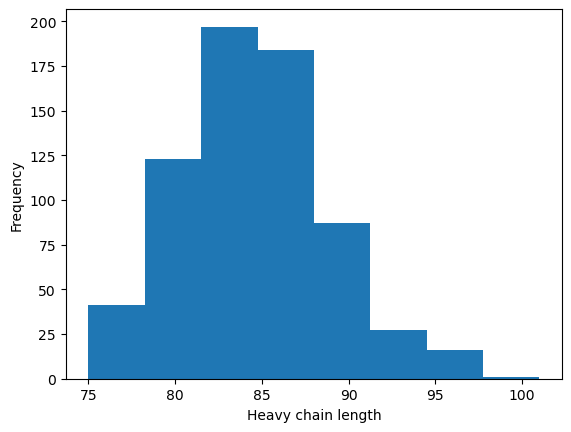

In [68]:
plt.hist(heavy, 8)
plt.xlabel('Heavy chain length')
plt.ylabel('Frequency')
plt.show()

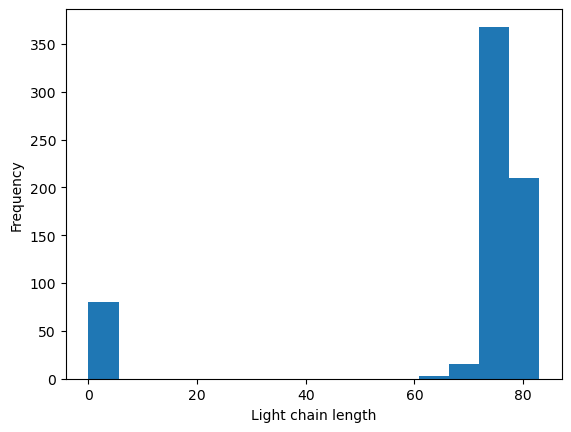

In [70]:
plt.hist(light, 15)
plt.xlabel('Light chain length')
plt.ylabel('Frequency')
plt.show()

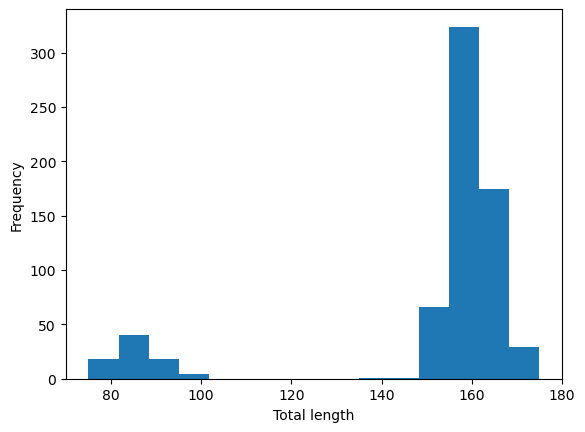

In [72]:
plt.hist([sum(x) for x in zip(heavy, light)], 15)
plt.xlabel('Total length')
plt.ylabel('Frequency')
plt.show()

In [39]:
# Code that obtains the longest/shortest possible chain

def noABC(residue):
    return residue[:-1]

residue_path = 'lists_of_residues/'
file_residues_paths = sorted(glob.glob(os.path.join('/Users/kevinmicha/Documents/PhD/predicting-affinity/'+residue_path, '*.npy')))
max_res_list = []

for f in file_residues_paths:
    current_list = np.load(f)[1:heavy[selected_entries.index(f[-8:-4])]+1]
    current_list = [x[1:] for x in current_list]
    max_res_list += list(set(current_list).difference(max_res_list))
    
max_res_list = sorted(max_res_list, key=noABC)
min_res_list = list(dict.fromkeys([x for x in max_res_list]))
max_res_list = [x.strip() for x in max_res_list]

for f in file_residues_paths:
    current_list = np.load(f)[1:heavy[selected_entries.index(f[-8:-4])]+1]
    current_list = [x[1:] for x in current_list]
    min_res_list = sorted(list(set(current_list).intersection(min_res_list)))

min_res_list = [x.strip() for x in min_res_list]

print('The longest chain has ' + str(len(max_res_list)) + ' residues, while the shortest has ' + str(len(min_res_list)))

The longest chain has 116 residues, while the shortest has 49


In [40]:
def generate_masked_image(img, idx, res_list=max_res_list, file_residues_paths=file_residues_paths, mode='fully-extended'):
    
    f = file_residues_paths[idx]
    
    current_list = np.load(f)[1:]#heavy[selected_entries.index(f[-8:-4])]+1]
    current_list = [x[1:].strip() for x in current_list]

    
    if mode == 'fully-cropped':
        idx_list = [i for i in range(len(current_list)) if current_list[i] in res_list]
        masked = img[idx_list,:][:,idx_list] 
        
    
    elif mode == 'fully-extended':
        max_res = len(res_list)
        masked = np.zeros((max_res, max_res))
        mask = np.zeros((max_res, max_res))
        idx_list = [i for i in range(max_res) if res_list[i] in current_list]
        for k, i in enumerate(idx_list):
            for l, j in enumerate(idx_list):
                masked[i, j] = img[k, l]
                mask[i, j] = 1

    else:
        raise NotImplementedError('Unknown mode: choose between fully-cropped and fully-extended')
        
    return masked, mask

In [41]:
# loading training images
imgs = []
kds = []
labels = []
data_path = '/Users/kevinmicha/Documents/PhD/predicting-affinity/' + dccm_map_path
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
for f in file_paths:
    pdb_id = f[-8:-4]
    if pdb_id in selected_entries:
        idx = entries.index(pdb_id)
        idx_new = selected_entries.index(pdb_id)
        labels.append(pdb_id)
        imgs.append(generate_masked_image(np.load(f), idx_new, max_res_list, file_residues_paths, 'fully-extended')[0])
        kds.append(np.log10(np.float32(affinity[idx])))

assert labels == selected_entries

for pdb in selected_entries:
    assert np.float16(10**kds[selected_entries.index(pdb)] == np.float16(df[df['pdb']==pdb]['affinity'])).all()

# converting the list to numpy array
#train_x = np.array(np.triu(imgs))
train_x = np.array(imgs)
# defining the target
train_y = np.array(kds)

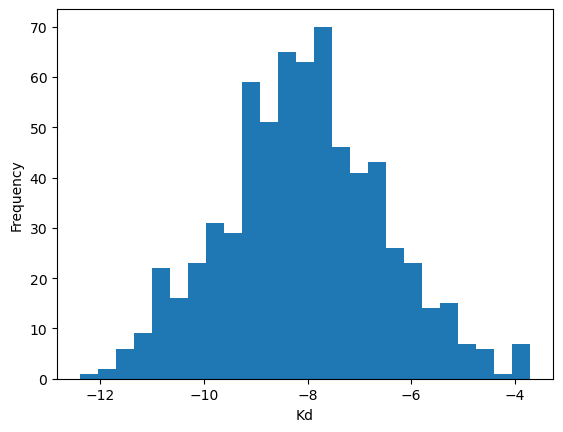

In [42]:
plt.hist(kds, 25)
plt.xlabel('Kd')
plt.ylabel('Frequency')
plt.show()

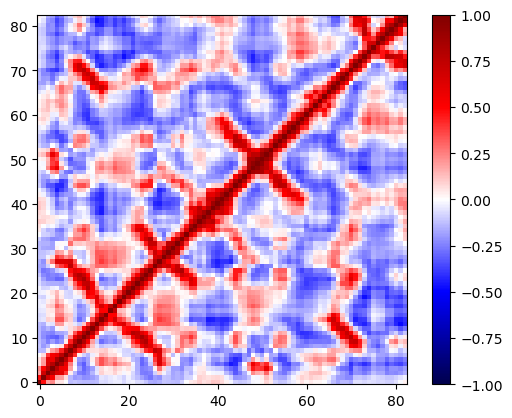

In [43]:
plt.imshow(np.load(file_paths[74]), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

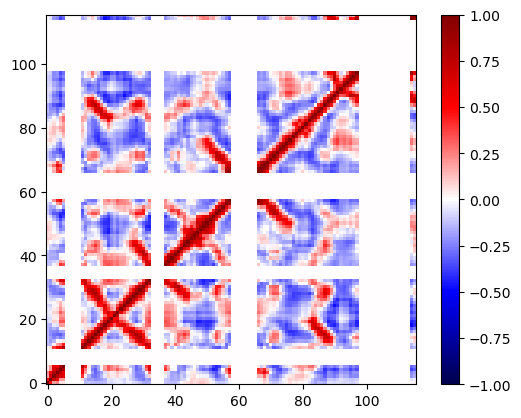

In [44]:
plt.imshow(train_x[74].reshape(train_x.shape[-1], train_x.shape[-1]), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

In [45]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.023, random_state=31)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((660, 116, 116), (660,)), ((16, 116, 116), (16,)))

In [46]:
# converting training images into torch format
train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[1])
train_x = train_x.astype(np.float32)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(np.float32).reshape(train_y.shape[0], 1)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([660, 1, 116, 116]), torch.Size([660, 1]))

In [47]:
# converting validation images into torch format
val_x = val_x.reshape(val_x.shape[0], 1, train_x.shape[2], train_x.shape[2])
val_x = val_x.astype(np.float32)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(np.float32).reshape(val_y.shape[0], 1)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([16, 1, 116, 116]), torch.Size([16, 1]))

In [48]:
n_filters = 3
filter_size = 5
pooling_size = 2
fully_connected_input = n_filters * ((train_x.shape[2] - filter_size + 1) // pooling_size) ** 2

class MultiLabelNN(Module):
    def __init__(self):
        super(MultiLabelNN, self).__init__()
        self.conv1 = Conv2d(1, n_filters, filter_size)
        #self.conv1.weight.data = self.conv1.weight.data#torch.tril(self.conv1.weight.data) + torch.transpose(torch.tril(self.conv1.weight.data), 2, 3)
        #self.conv1.weight.data.fill_(1e-5)
        self.pool = MaxPool2d(pooling_size, pooling_size)
        #self.conv2 = Conv2d(n_filters, n_filters, filter_size+2)
        #self.conv2.weight.data = torch.tril(self.conv2.weight.data) + torch.transpose(torch.tril(self.conv2.weight.data), 2, 3)
        #self.conv2.weight.data = torch.transpose(self.conv2.weight.data, 2, 3)
        self.relu = ReLU()
        self.fc1 = Linear(fully_connected_input, 1, bias=False)
        #self.fc2 = Linear(128, 1)
        self.dropit = Dropout(p=0.05)
        #self.fc3 = Linear(128, 64)
        #self.fc4 = Linear(64, 1)

    def forward(self, x):
       #shape of x is (b_s, 32,32,1)
        x = self.conv1(x) + torch.transpose(self.conv1(x), 2, 3)#shape of x is (b_s, 28,28,132)
        x = self.relu(x)
        x = self.pool(x) #shape of x now becomes (b_s X 14 x 14 x 32)
        #x = self.conv2(x) # shape(b_s, 10x10x64)
        inter = x = self.relu(x)#size is (b_s x 10 x 10 x 64)
        #inter = x
        x = x.view(x.size(0), -1) # shape of x is now(b_s*2, 3200)
        #this is the problem 
        #you can fc1 to be of shape (6400,1024) and that will work 
        x = self.dropit(x)
        x = self.fc1(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        #x = self.relu(x)
        #x = self.fc3(x)
        #x = self.relu(x)
        #x = self.fc4(x)


        return x.float(), inter


In [49]:
# defining the model
model = MultiLabelNN()
# defining the optimizer
#optimizer = Adam(model.parameters(), lr=2e-3)
#optimizer = AdamW(model.parameters(), lr=1.75e-3)
optimizer = AdaBelief(model.parameters(), lr=1e-3, eps=1e-8, weight_decouple=False) #1.55 for pool=2
#optimizer = SGD(model.parameters(), lr=9e-4)
#scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.5, total_iters=120, verbose=True)
# 0.5 120
# 0.25 181
# 0.125

# defining the loss function
criterion = MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Rectification enabled in AdaBelief
MultiLabelNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool):

In [50]:
train_x.size()[0]

660

In [51]:
def train(epoch):
    model.train()
    tr_loss = 0
    batch_size = 32
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)

    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    inter_filter = np.zeros((x_train.size()[0], n_filters, 56, 56))
    
    
    permutation = torch.randperm(x_train.size()[0])
    #val_indices = torch.randperm(x_val.size()[0])[:1]

    for i in range(0, x_train.size()[0], batch_size):

        
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        
        # prediction for training and validation set
        output_train, inter_filters = model(batch_x)
        
        inter_filter[i:i+batch_size] = inter_filters.detach().numpy()

        # computing the training loss
        loss_train = torch.std(batch_y) * criterion(output_train, batch_y)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
        
        loss_train /= torch.std(batch_y)
        
        # clearing the Gradients of the model parameters
        optimizer.zero_grad(set_to_none=True)
        
        tr_loss += loss_train.item() * batch_size / x_train.size()[0]
    output_val, _ = model(x_val)#[val_indices])
    loss_val = criterion(output_val, y_val)#[val_indices])
    train_losses.append(tr_loss)
    val_losses.append(loss_val)
    
    # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'train loss: ', tr_loss, 'val loss :', loss_val)
    print(output_val)
    print(y_val)#[val_indices])
        
    return tr_loss, loss_val, inter_filter, batch_y, y_val, output_val, permutation


In [135]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

In [45]:
for i in range(1):# defining the number of epochs
    n_max_epochs = 100

    # training the model
    for epoch in range(n_max_epochs):
        tr_loss, val_loss, inter_filter, y_tr, y_val, output_val, perm = train(epoch)
        #scheduler.step()
        if tr_loss < 0.67 and val_loss < 0.65 or val_loss < 0.5:
            break

Epoch :  1 	 train loss:  0.6446893952109597 val loss : tensor(0.9389, grad_fn=<MseLossBackward0>)
tensor([[ -9.1033],
        [ -9.2172],
        [ -8.1906],
        [-10.3679],
        [ -8.1162],
        [ -6.8898],
        [ -9.3484],
        [ -9.3936],
        [ -8.4442],
        [ -5.5630],
        [ -7.6195],
        [ -8.3004],
        [ -8.2221],
        [ -7.2795],
        [ -9.6990],
        [ -7.5219]], grad_fn=<MmBackward0>)
tensor([[ -7.9586],
        [ -6.7905],
        [ -7.7959],
        [-11.3979],
        [ -8.4318],
        [ -6.9208],
        [ -7.7696],
        [ -9.3010],
        [ -8.8861],
        [ -6.0410],
        [ -8.5376],
        [ -7.6021],
        [ -8.1643],
        [ -7.6840],
        [ -9.7696],
        [ -6.0804]])
Epoch :  2 	 train loss:  0.6786574464855771 val loss : tensor(0.9220, grad_fn=<MseLossBackward0>)
tensor([[-9.0707],
        [-7.8172],
        [-9.3232],
        [-9.9880],
        [-8.3271],
        [-7.7413],
        [-9.6362],
    

Epoch :  12 	 train loss:  0.6831099394595984 val loss : tensor(0.6297, grad_fn=<MseLossBackward0>)
tensor([[-8.8313],
        [-7.7942],
        [-8.3443],
        [-9.4301],
        [-8.7507],
        [-7.5938],
        [-8.1310],
        [-9.5126],
        [-8.5067],
        [-6.3818],
        [-7.3660],
        [-8.2723],
        [-7.9429],
        [-7.0364],
        [-9.2988],
        [-6.8745]], grad_fn=<MmBackward0>)
tensor([[ -7.9586],
        [ -6.7905],
        [ -7.7959],
        [-11.3979],
        [ -8.4318],
        [ -6.9208],
        [ -7.7696],
        [ -9.3010],
        [ -8.8861],
        [ -6.0410],
        [ -8.5376],
        [ -7.6021],
        [ -8.1643],
        [ -7.6840],
        [ -9.7696],
        [ -6.0804]])
Epoch :  13 	 train loss:  0.6566073345415521 val loss : tensor(1.2674, grad_fn=<MseLossBackward0>)
tensor([[ -9.0728],
        [ -8.3638],
        [ -8.8314],
        [ -9.8039],
        [ -9.1268],
        [ -7.9082],
        [-10.3997],
        [ -

In [46]:
#optimizer = AdaBelief(model.parameters(), lr=4e-4, eps=1e-8, weight_decouple=False) # th 4e-4 and 8e-4
# 150 (scheduler from 3e-3 to 1.5e-3 in 120 ep), 150, ..., and finally 150 (lr=8e-4)

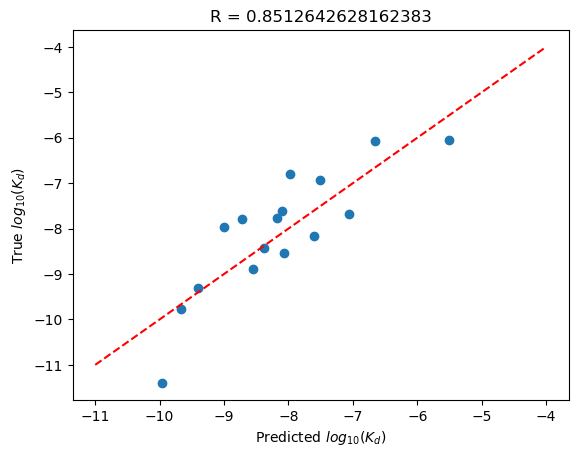

In [47]:
plt.scatter(output_val.detach().numpy(), y_val.detach().numpy())
corr = np.corrcoef(output_val.detach().numpy().T, y_val.detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr))
plt.xlabel('Predicted $log_{10}$($K_d$)')
plt.ylabel('True $log_{10}$($K_d$)')
plt.show()

In [48]:
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
size_le

56

In [49]:
inter_filter.shape

(660, 3, 56, 56)

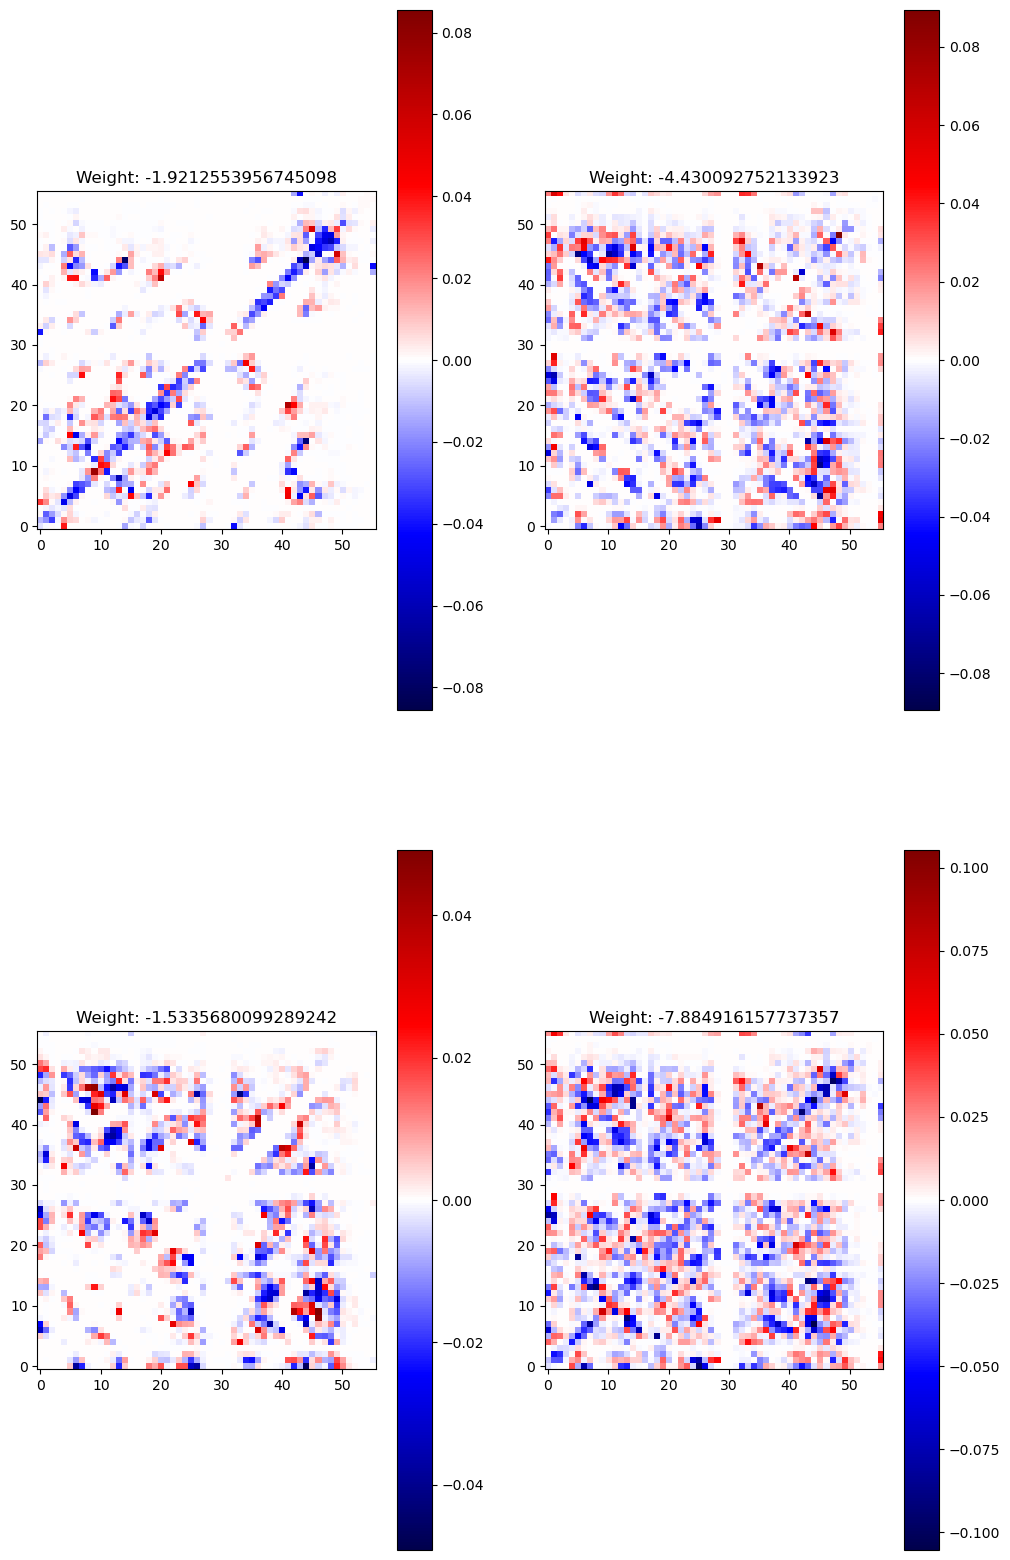

In [57]:
import itertools

fig, axs = plt.subplots((n_filters+1)//2, 2, figsize=(12, 20))
img = np.zeros((size_le, size_le))

for i, j in itertools.product(range((n_filters+1)//2), range(2)):
    if j == 1 and i == (n_filters+1)//2-1 and n_filters % 2 != 0:
        im_ = img
    else:
        im_ = np.multiply(np.mean(inter_filter, axis=0)[2*i+j], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[2*i+j].reshape(size_le, size_le))
        img += im_
    im = axs[i,j].imshow(im_, origin='lower', cmap='seismic', norm=CenteredNorm())
    plt.colorbar(im, ax=axs[i,j])
    axs[i,j].set_title('Weight: '+str(im_.sum()))

-7.884916157737357

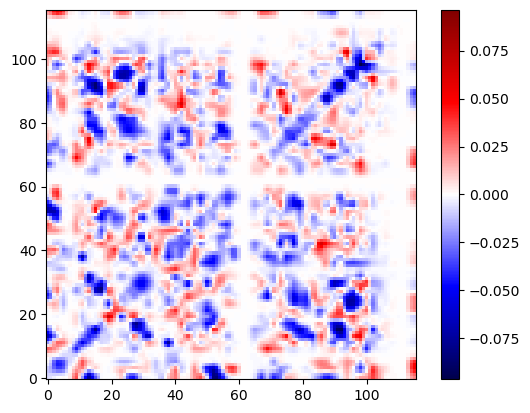

In [58]:
plt.imshow(cv2.resize(img, dsize=(116, 116)), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()
img.sum()

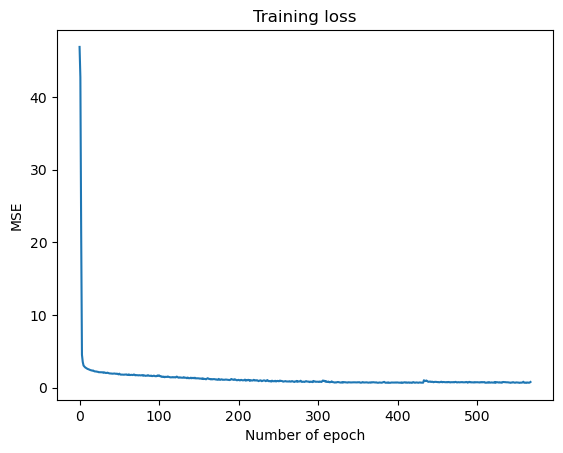

In [59]:
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.show()

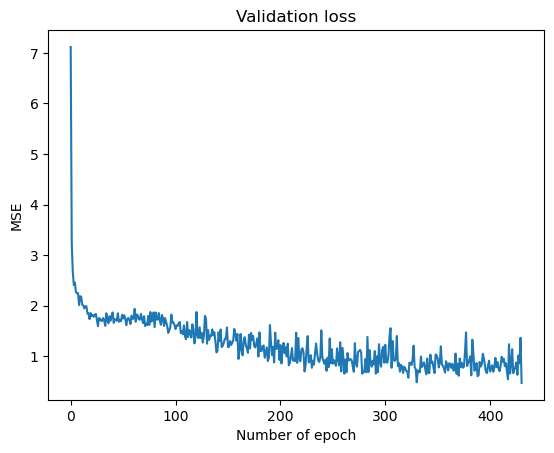

In [52]:
plt.plot([val_losses[2:][i].detach().numpy() for i in range(len(val_losses[2:]))])
plt.title('Validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.show()

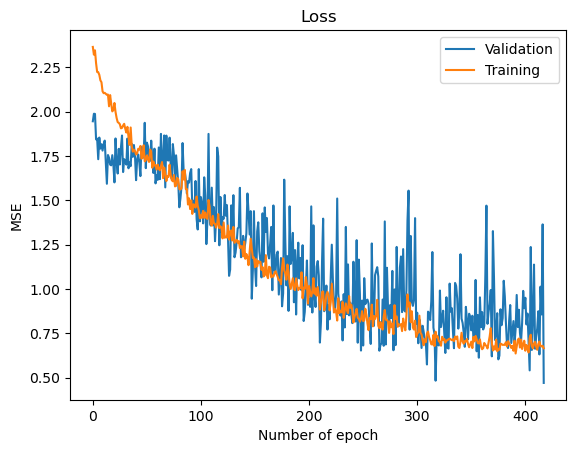

In [53]:
plt.plot([val_losses[15:][i].detach().numpy() for i in range(len(val_losses[15:]))])
plt.plot([train_losses[15:][i] for i in range(len(train_losses[15:]))])
plt.title('Loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.legend(['Validation', 'Training'])
plt.show()

In [55]:
model.eval()
model(Variable(train_x[40:80]))[0]

tensor([[ -7.4601],
        [ -8.3040],
        [ -9.1345],
        [ -8.3274],
        [ -7.0737],
        [ -5.4219],
        [ -7.5954],
        [ -9.7071],
        [ -6.4725],
        [ -8.3250],
        [ -6.9556],
        [ -7.9207],
        [ -6.9513],
        [ -8.8318],
        [ -5.9890],
        [ -6.8763],
        [ -8.2083],
        [ -8.6702],
        [-10.2108],
        [ -8.6470],
        [ -4.3311],
        [ -6.9984],
        [ -8.1758],
        [ -8.6322],
        [ -9.0783],
        [ -6.2118],
        [ -7.2379],
        [-10.4055],
        [ -9.1873],
        [ -7.4601],
        [ -7.7119],
        [ -6.4368],
        [ -7.5073],
        [ -8.8803],
        [ -6.5512],
        [ -6.7070],
        [ -8.5396],
        [ -5.5003],
        [ -6.2841],
        [ -6.9942]], grad_fn=<MmBackward0>)

In [44]:
Variable(train_y[40:80])

tensor([[ -7.7212],
        [ -7.8539],
        [ -8.3872],
        [ -9.1267],
        [ -7.3665],
        [ -5.4685],
        [ -7.9208],
        [-10.5452],
        [ -5.9747],
        [ -8.6576],
        [ -7.3565],
        [ -8.7645],
        [ -6.5229],
        [ -8.4318],
        [ -6.1024],
        [ -6.5086],
        [ -8.5376],
        [ -9.9393],
        [-11.3979],
        [ -8.4473],
        [ -4.7959],
        [ -5.8327],
        [ -8.2218],
        [ -9.7375],
        [ -9.0362],
        [ -6.3615],
        [ -8.1463],
        [-10.6990],
        [ -9.3010],
        [ -7.7212],
        [ -8.0605],
        [ -6.2840],
        [ -7.9586],
        [ -9.0000],
        [ -5.5686],
        [ -6.0794],
        [-11.5229],
        [ -6.0458],
        [ -6.6990],
        [ -7.4685]])

In [192]:
file_paths

['/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1a4k.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1aj7.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1axs.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1bj1.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1bvk.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1c12.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1c5c.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1ct8.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1cz8.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1d6v.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dbb.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dee.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dl7.npy',
 '/Users/kevinmicha/Docum

In [128]:
entry = '1t66'
download_path = '/Users/kevinmicha/Downloads/'
file_name = entry + numbering + selection
path = folder + file_name + file_type_input
new_path = download_path + entry + '_map'
generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input, lresidues=False)  
subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))

if os.path.exists(path):
    os.remove(path)
h, l = np.load(download_path + 'value.npy') 

f = download_path + entry + '_map' + '.npy'
res_path = np.array([download_path + entry + '_residues' + '.npy'])
test_array, mask = generate_masked_image(np.load(f), idx=0, res_list=max_res_list, file_residues_paths=res_path, mode='fully-extended')
test_sample = torch.from_numpy(test_array.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))

# this value should be in the -7 to -4 interval
model.eval()
model(test_sample)[0]

tensor([[-5.7029]], grad_fn=<MmBackward0>)

In [129]:
prediction = 10**model(test_sample)[0].detach().numpy()
prediction

array([[1.9821491e-06]], dtype=float32)

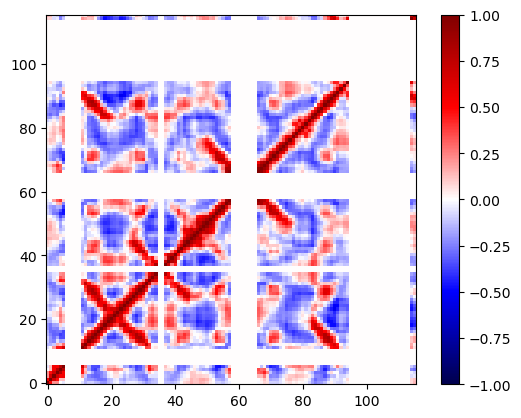

In [130]:
plt.imshow(test_array, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

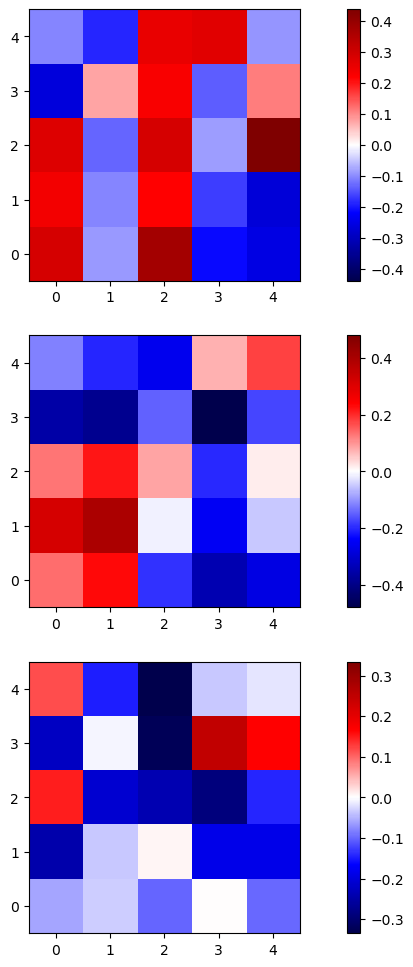

In [70]:
import itertools

fig, axs = plt.subplots(n_filters, 1, figsize=(12, 12))
conv_filters = deepcopy(model.conv1.weight.data.numpy())
                           
for i, j in itertools.product(range(n_filters), range(1)):
    im = axs[i].imshow(conv_filters[i+j][0], origin='lower', cmap='seismic', norm=CenteredNorm())
    #axs[i].set_xticks([0, 6.25, 20], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    #axs[i].set_yticks([0, 6.25, 20], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])

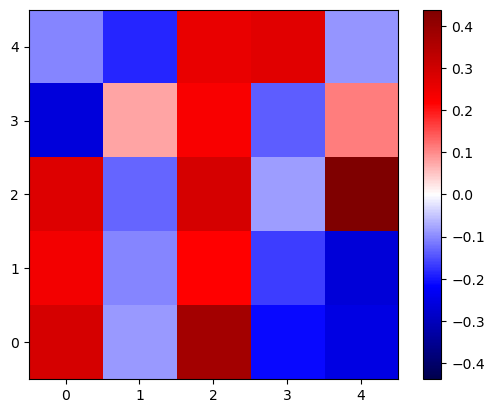

In [71]:
plt.imshow(np.mean(conv_filters[0,...], axis=0), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

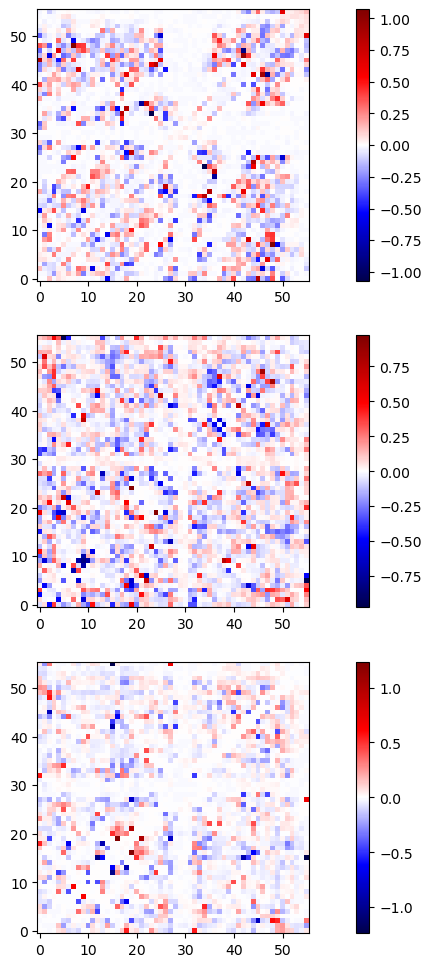

In [72]:
fig, axs = plt.subplots(n_filters, 1, figsize=(12, 12))

fully_connected = deepcopy(model.fc1.weight.data.numpy().reshape(n_filters, size_le**2))
#fully_connected = np.where(abs(fully_connected)<0.05, 0, fully_connected)

for i, j in itertools.product(range(n_filters), range(1)):
    im = axs[i].imshow(fully_connected[i].reshape(size_le, size_le), origin='lower', cmap='seismic', norm=CenteredNorm())
    #axs[i].set_xticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    #axs[i].set_yticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])


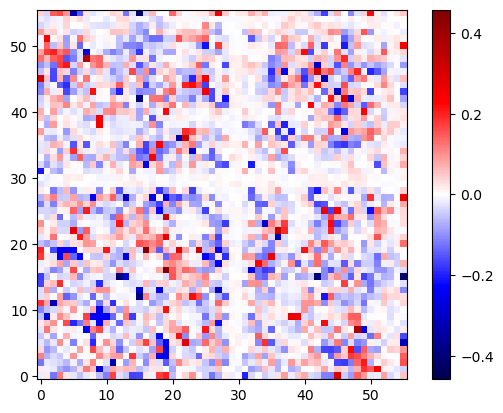

In [73]:
plt.imshow(np.mean(fully_connected.reshape(n_filters, size_le, size_le), axis=0), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

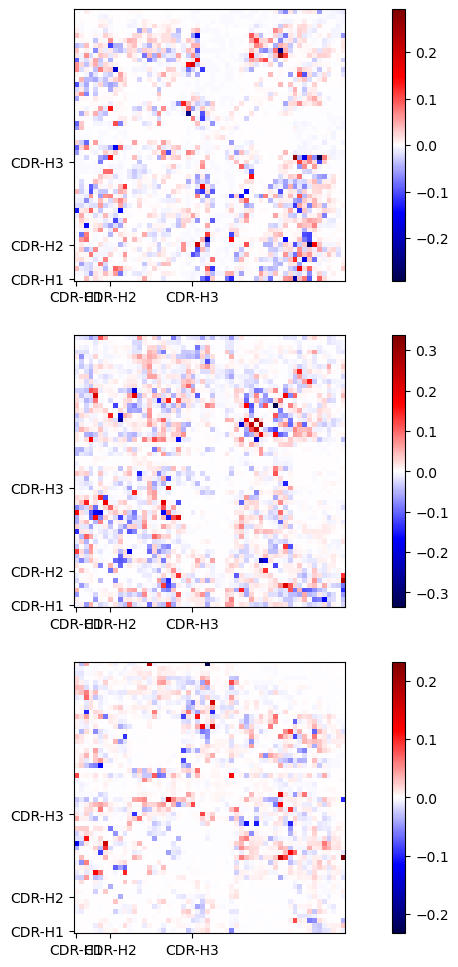

In [74]:
fig, axs = plt.subplots(n_filters, 1, figsize=(12, 12))

imgg = np.zeros((size_le, size_le))
for i, j in itertools.product(range(n_filters), range(1)):
    conv_bank = cv2.resize(conv_filters[i,0,...], dsize=(size_le, size_le), interpolation=cv2.INTER_AREA)
    #new_img = np.multiply(np.where(conv_bank<-3,0,conv_bank), fully_connected[i].reshape(15, 15)) 
    new_img = np.multiply(conv_bank, fully_connected[i].reshape(size_le, size_le)) #+ model.fc1.bias.data.numpy()
    im = axs[i].imshow(new_img, origin='lower', cmap='seismic', norm=CenteredNorm())
    axs[i].set_xticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])
    imgg += new_img

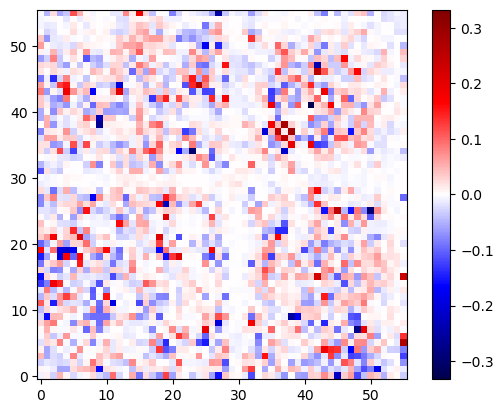

In [75]:
#blue = "need blue in dccm"
#yellow = "need red in dccm"
plt.imshow(np.where(abs(imgg)<0.002, 0, imgg), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()
plt.show()

In [1395]:
imgg.sum()

2.959946501930741

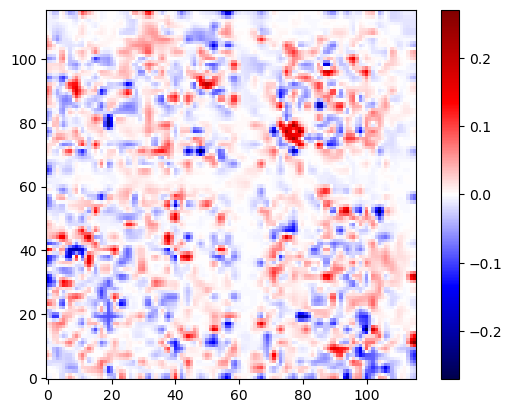

In [76]:
plt.imshow(cv2.resize(imgg, dsize=(train_x.shape[2], train_x.shape[2])), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

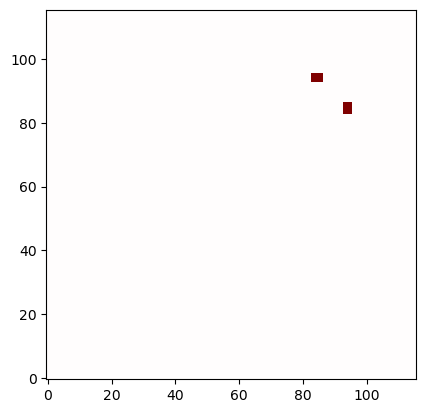

In [77]:
#Arbitrary mask analysis
test_mask = np.zeros((train_x.shape[2], train_x.shape[2]))
test_mask[93:96, 83:87] = 1
test_mask += np.transpose(test_mask)
plt.imshow(test_mask, origin='lower', cmap='seismic', norm=CenteredNorm())

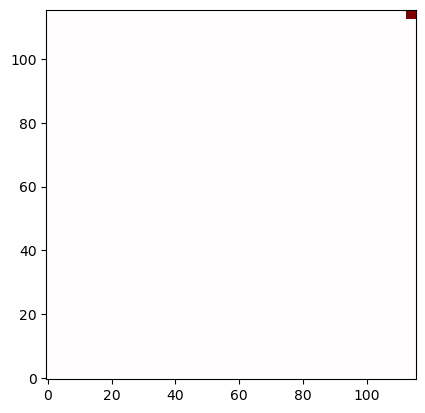

In [78]:
#CDR-H3 analysis
cdr3_mask = np.zeros((train_x.shape[2], train_x.shape[2]))
cdr3_mask[-3:, -3:] = 1
plt.imshow(cdr3_mask, origin='lower', cmap='seismic', norm=CenteredNorm())

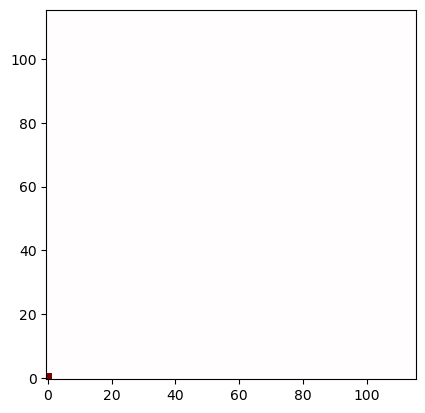

In [79]:
#CDR-H1 analysis
cdr1_mask = np.zeros((train_x.shape[2], train_x.shape[2]))
cdr1_mask[:2, :2] = 1
plt.imshow(cdr1_mask, origin='lower', cmap='seismic', norm=CenteredNorm())

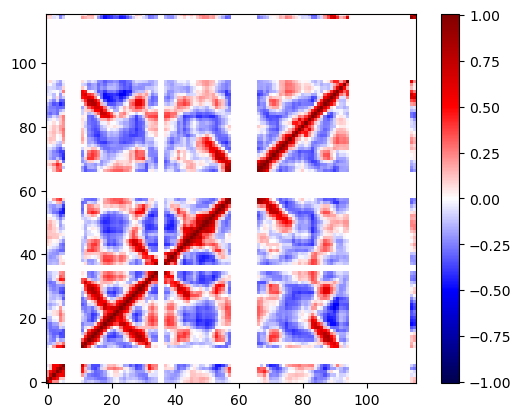

In [80]:
img_factor = 0.1
cdr3_factor = 0
cdr1_factor = 0
test_factor = 0


ideal = test_array + np.multiply(mask, img_factor * cv2.resize(img, dsize=(train_x.shape[2], train_x.shape[2])) + cdr3_factor * cdr3_mask  + cdr1_factor * cdr1_mask + test_factor * test_mask)
plt.imshow(ideal, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

In [81]:
model.eval()
new_prediction = 10**model(torch.from_numpy(ideal.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32)))[0].detach().numpy()
per_change = ((prediction - new_prediction) / prediction * 100)[0][0]
print(new_prediction)
print('Adding/subtracting the obtained map with a factor of', img_factor, 'makes Kd smaller by', per_change, '%')

[[2.510875e-06]]
Adding/subtracting the obtained map with a factor of 0.1 makes Kd smaller by 23.0811 %


In [82]:
high_aff = []
low_aff = []

for i in range(train_y.detach().numpy().shape[0]):
    if train_y.detach().numpy()[i][0] < -8:
        high_aff.append(train_x.detach().numpy()[i])
    elif train_y.detach().numpy()[i][0] > -8:
        low_aff.append(train_x.detach().numpy()[i])
        
mean_image = np.mean(train_x.detach().numpy(), axis=0).reshape(train_x.shape[-1], train_x.shape[-1])
mask_mean_image = -1 * np.sign(mean_image) 
mean_diff_image = np.mean(high_aff, axis=0)-np.mean(low_aff, axis=0)

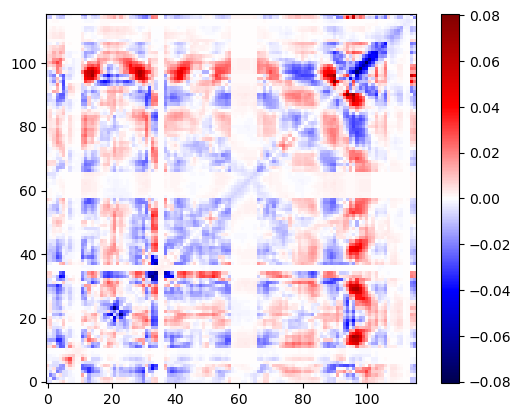

In [83]:
plt.imshow(mean_diff_image[0], origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

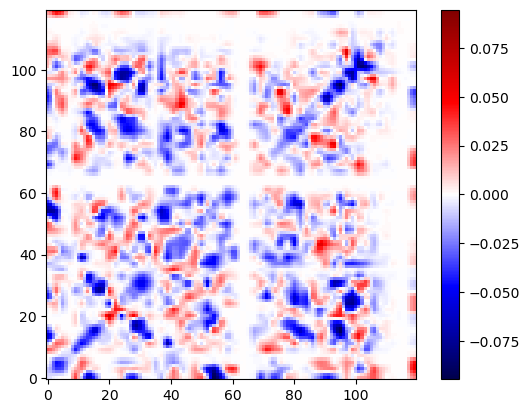

In [84]:
plt.imshow(cv2.resize(img, dsize=(120, 120)), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

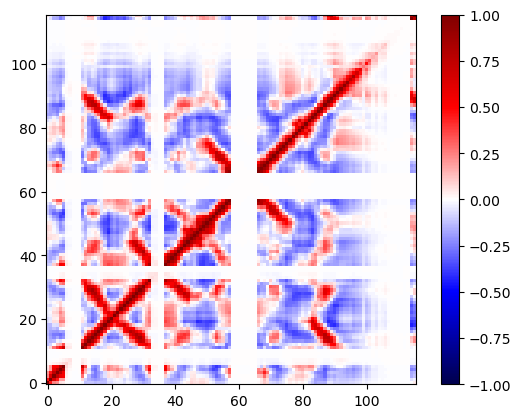

In [85]:
plt.imshow(mean_image, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

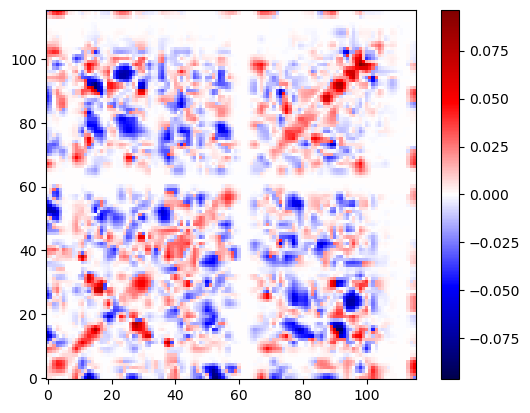

In [86]:
plt.imshow(np.multiply(cv2.resize(img, dsize=(116, 116)), mask_mean_image), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

## Finding correlations between actual strucutres

In [88]:
def pooling(mat, ksize, method='max', pad=False):
    '''Non-overlapping pooling on 2D or 3D data.

    <mat>: ndarray, input array to pool.
    <ksize>: tuple of 2, kernel size in (ky, kx).
    <method>: str, 'max for max-pooling, 
                   'mean' for mean-pooling.
    <pad>: bool, pad <mat> or not. If no pad, output has size
           n//f, n being <mat> size, f being kernel size.
           if pad, output has size ceil(n/f).

    Return <result>: pooled matrix.
    '''

    m, n = mat.shape[:2]
    ky,kx = ksize

    _ceil = lambda x,y: int(np.ceil(x/float(y)))

    if pad:
        ny = _ceil(m,ky)
        nx = _ceil(n,kx)
        size = (ny*ky, nx*kx) + mat.shape[2:]
        mat_pad = np.full(size,numpy.nan)
        mat_pad[:m,:n,...] = mat
    else:
        ny = m // ky
        nx = n // kx
        mat_pad = mat[:ny*ky, :nx*kx, ...]

    new_shape = (ny,ky,nx,kx) + mat.shape[2:]

    if method == 'max':
        result = np.nanmax(mat_pad.reshape(new_shape), axis=(1,3))
    else:
        result = np.nanmean(mat_pad.reshape(new_shape), axis=(1,3))

    return result

In [89]:
perm.detach().numpy()

array([600, 467,  25, 339, 327, 509, 137, 248, 234, 648, 526,  89, 602,
       189, 489, 296, 139, 236, 231, 346, 401, 340, 414, 647, 301, 305,
       619,  43, 634, 277, 286, 280, 239, 474, 107, 504, 214,  49, 421,
       357, 282, 519, 622, 593, 161, 607, 190, 393,  81, 345, 655, 304,
       585, 372, 306, 272,  35, 271, 500, 443, 524, 415,  85,  27, 131,
       127, 392,  82, 172, 441, 264, 450, 260, 552, 560, 555,  64, 597,
        75, 367, 247, 108, 150, 389, 325, 175,  97, 360, 369,   2, 511,
       347, 570,  51, 223, 427, 577, 627, 413,  50,  15, 278, 117, 429,
       103, 168,   9, 636, 227, 375, 578, 497, 179, 574, 311, 432, 455,
       658, 640, 308, 160, 478, 423, 173, 213, 267, 615, 580, 199, 320,
       338, 425, 475, 575, 352, 381, 222, 408, 436, 433, 319,  96, 148,
       180, 201,  45, 273, 382, 245, 118, 323,  74, 126,  42, 140, 521,
       517, 402, 142, 235,  57,  84,  44, 376,  13,  19, 288,  90, 182,
        41, 484, 629, 251, 610, 549, 317,  14, 573, 398,  32, 63

In [90]:
each_img = np.zeros((train_x.shape[0], inter_filter.shape[2], inter_filter.shape[3]))
each_img_enl = np.zeros((train_x.shape[0], train_x.shape[2], train_x.shape[3]))


for j in range(train_x.shape[0]):
    for i in range(n_filters):
        each_img[j] += np.multiply(inter_filter[j,i], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[i].reshape(size_le, size_le))
        each_img_enl[j] += ((56/116) ** 2) * cv2.resize(np.multiply(inter_filter[j,i], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[i].reshape(size_le, size_le)), dsize=(116,116))

In [108]:
high_aff = []
low_aff = []

for j, i in enumerate(list(perm.detach().numpy())):
    high_aff.append(np.multiply(-np.clip(each_img_enl[j], a_min=-np.inf, a_max=0), cv2.resize(pooling(train_x.detach().numpy()[i][0], (1,1)), dsize=(116, 116))))
    low_aff.append(np.multiply(np.clip(each_img_enl[j], a_min=0, a_max=np.inf), cv2.resize(pooling(train_x.detach().numpy()[i][0], (1,1)), dsize=(116, 116))))

true_filter = deepcopy(np.mean(high_aff, axis=0) - np.mean(low_aff, axis=0))

0.5872731552410951

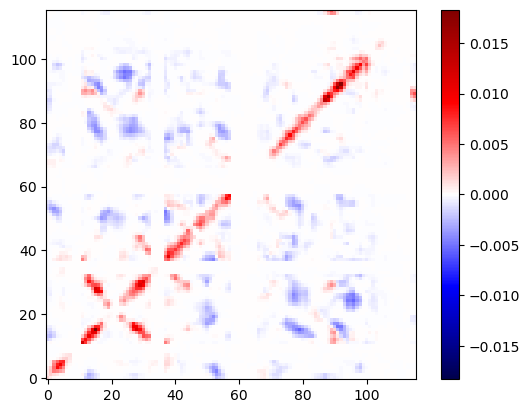

In [109]:
plt.imshow(np.mean(high_aff, axis=0), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()
np.mean(high_aff, axis=0).sum()

-0.23944191708417412

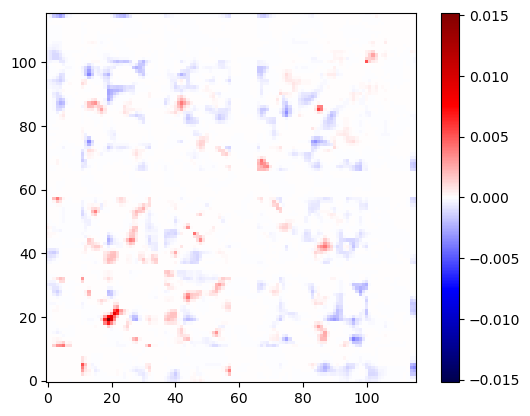

In [110]:
plt.imshow(np.mean(low_aff, axis=0), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()
np.mean(low_aff, axis=0).sum()

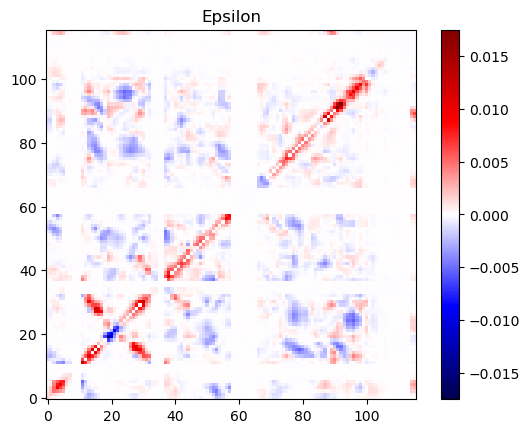

In [119]:
plt.imshow(np.multiply(np.abs(np.sign(mean_diff_image[0])), true_filter), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Epsilon')
plt.colorbar()

In [112]:
high_aff = []
low_aff = []

for j, i in enumerate(list(perm.detach().numpy())):
    if train_y.detach().numpy()[i][0] < -8:
        high_aff.append(each_img_enl[j])
    elif train_y.detach().numpy()[i][0] > -8:
        low_aff.append(each_img_enl[j])
        
diff_filter = deepcopy(np.mean(high_aff, axis=0) - np.mean(low_aff, axis=0))

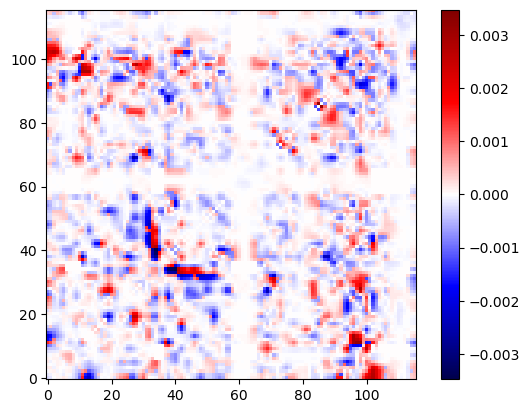

In [113]:
plt.imshow(-np.multiply(np.sign(mean_diff_image[0]), diff_filter), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()
plt.show()

In [121]:
cdr1_coord = range(max_res_list.index('26'), max_res_list.index('33'))
cdr2_coord = range(max_res_list.index('52'), max_res_list.index('57'))
cdr3_coord = range(max_res_list.index('95'), max_res_list.index('102')+1)
beta11_coord = range(max_res_list.index('33'), max_res_list.index('39'))
beta12_coord = range(max_res_list.index('45'), max_res_list.index('51'))
beta13_coord = range(max_res_list.index('57'), max_res_list.index('61'))
beta14_coord = range(max_res_list.index('89'), max_res_list.index('95'))
beta21_coord = range(max_res_list.index('67'), max_res_list.index('72'))
beta22_coord = range(max_res_list.index('75'), max_res_list.index('82'))
alpha_coord = range(max_res_list.index('84'), max_res_list.index('87'))

#masked_img = np.multiply(cv2.resize(img, dsize=(116, 116)), mask_mean_image)
#masked_img = np.multiply(cv2.resize((img-img.max())/(img.min()-img.max()), dsize=(116, 116)), mean_diff_image)
#masked_img = cv2.resize(img, dsize=(116, 116))
#masked_img = mean_diff_image
#masked_img = corr_matrix.reshape(116, 116)
#masked_img = np.multiply(-np.sign(mean_diff_image[0]), mean_filter)
masked_img = np.multiply(np.abs(np.sign(mean_diff_image[0])), deepcopy(true_filter))
rmax = np.abs(masked_img).max()

ticks = [cdr1_coord[0], (cdr1_coord[-1]+beta11_coord[0])/2, beta11_coord[-1], beta12_coord[0], beta12_coord[-1], cdr2_coord[0], (cdr2_coord[-1]+beta13_coord[0])/2, beta13_coord[-1], beta21_coord[0], beta21_coord[-1],
         beta22_coord[0], beta22_coord[-1], beta14_coord[0], (beta14_coord[-1]+cdr3_coord[0])/2, cdr3_coord[-1]]

ticks_labels = ['CDR-H1_i', 'CDR-H1_f & Beta11_i', 'Beta11_f', 'Beta12_i', 'Beta12_f', 'CDR-H2_i', 'CDR-H2_f & Beta13_i', 'Beta13_f', 'Beta21_i', 'Beta21_f', 'Beta22_i', 'Beta22_f', 'Beta14_i', 'Beta14_f & CDR-H3_i', 'CDR-H3_f']

In [122]:
rmax

0.017514437301745723

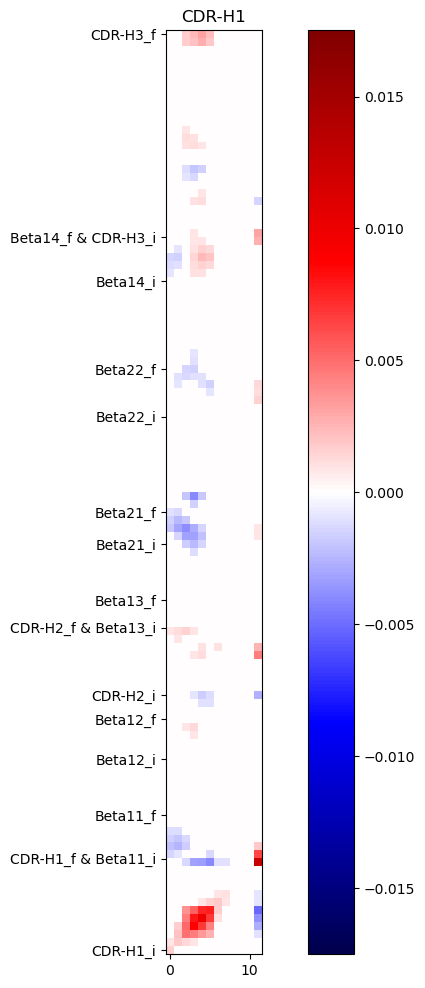

0.09842479958392483


In [126]:
plt.figure(figsize=(12, 12))
cdr1_corr = masked_img[:, cdr1_coord]
plt.imshow(np.where(abs(cdr1_corr)<abs(cdr1_corr).max()/15, 0, cdr1_corr), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('CDR-H1')
plt.show()
print(cdr1_corr.sum())

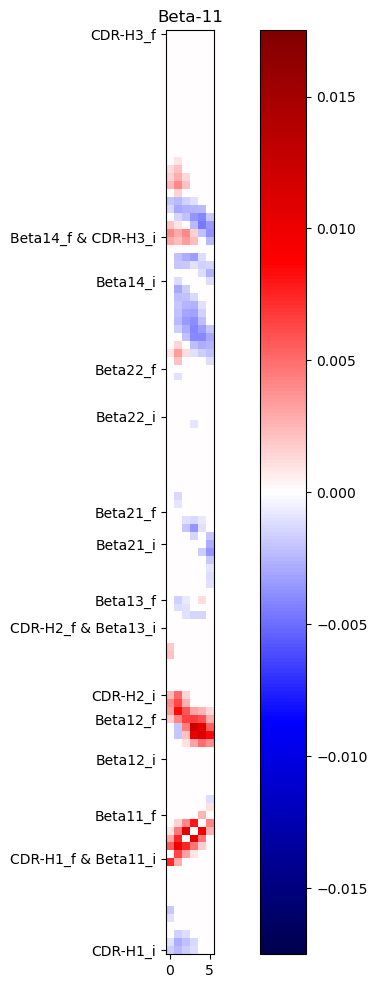

0.11111088522055879


In [127]:
plt.figure(figsize=(12, 12))
beta11_corr = masked_img[:, beta11_coord]
plt.imshow(np.where(abs(beta11_corr)<abs(beta11_corr).max()/15, 0, beta11_corr), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-11')
plt.show()
print(beta11_corr.sum())

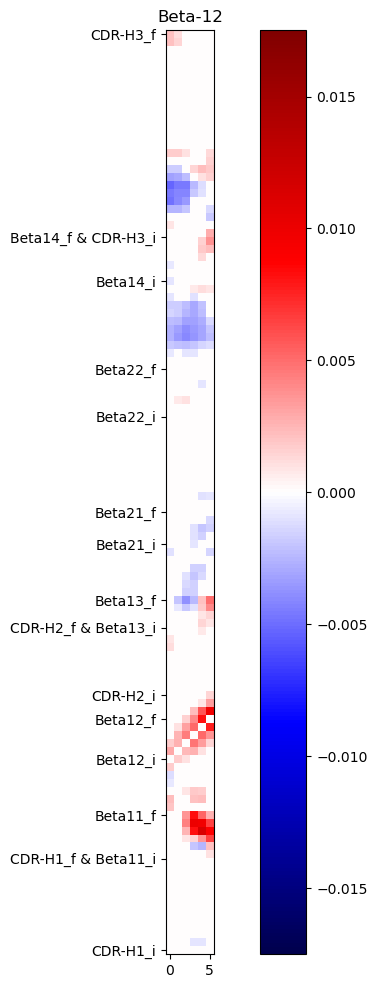

0.04561449225417663


In [128]:
plt.figure(figsize=(12, 12))
beta12_corr = masked_img[:, beta12_coord]
plt.imshow(np.where(abs(beta12_corr)<abs(beta12_corr).max()/15, 0, beta12_corr), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-12')
plt.show()
print(beta12_corr.sum())

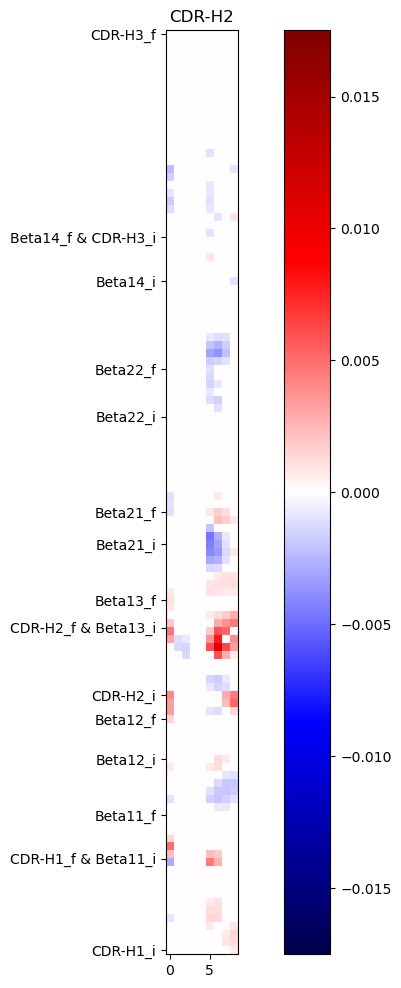

0.056553011046102775


In [129]:
plt.figure(figsize=(12, 12))
cdr2_corr = masked_img[:, cdr2_coord]
plt.imshow(np.where(abs(cdr2_corr)<abs(cdr2_corr).max()/15, 0, cdr2_corr), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('CDR-H2')
plt.show()
print(cdr2_corr.sum())

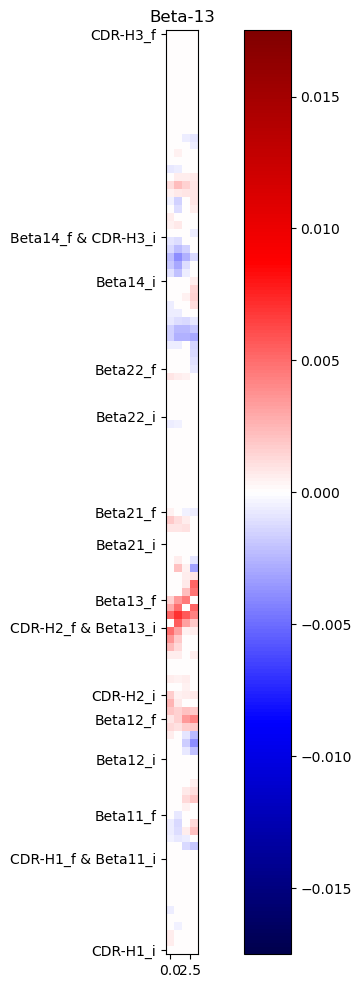

0.07066080520081158


In [130]:
plt.figure(figsize=(12, 12))
beta13_corr = masked_img[:, beta13_coord]
plt.imshow(np.where(abs(beta13_corr)<abs(beta13_corr).max()/15, 0, beta13_corr), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-13')
plt.show()
print(beta13_corr.sum())

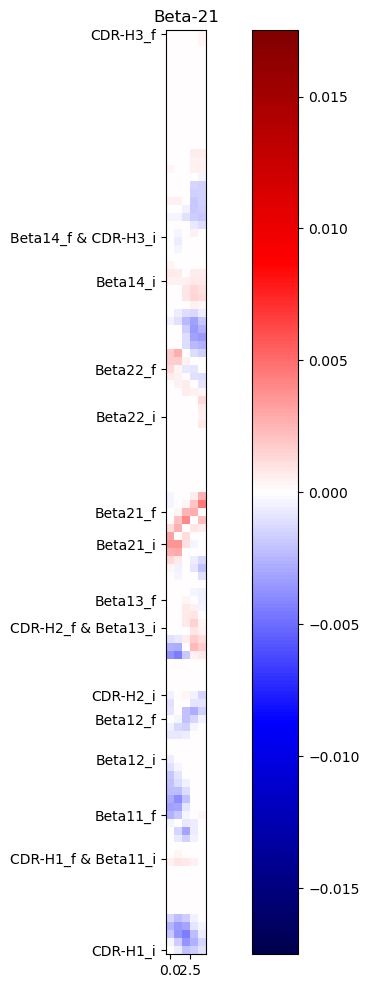

-0.0985554198650943


In [131]:
plt.figure(figsize=(12, 12))
beta21_corr = masked_img[:, beta21_coord]
plt.imshow(np.where(abs(beta21_corr)<abs(beta21_corr).max()/15, 0, beta21_corr), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-21')
plt.show()
print(beta21_corr.sum())

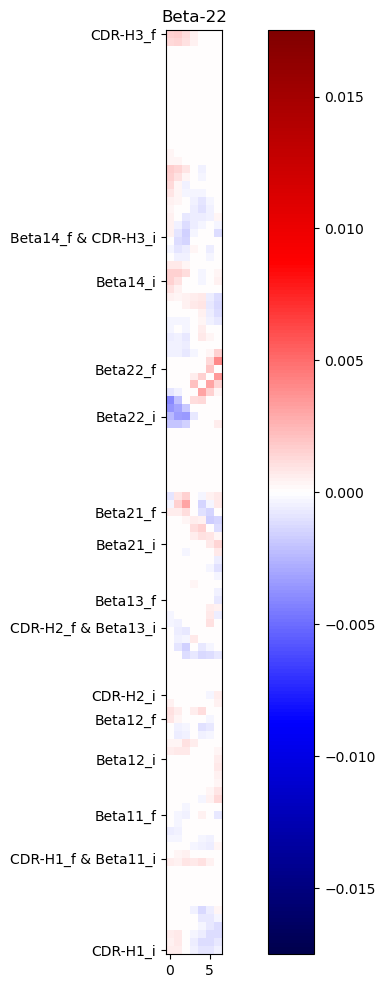

-0.000746106435093972


In [132]:
plt.figure(figsize=(12, 12))
beta22_corr = masked_img[:, beta22_coord]
plt.imshow(np.where(abs(beta22_corr)<abs(beta22_corr).max()/15, 0, beta22_corr), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-22')
plt.show()
print(beta22_corr.sum())

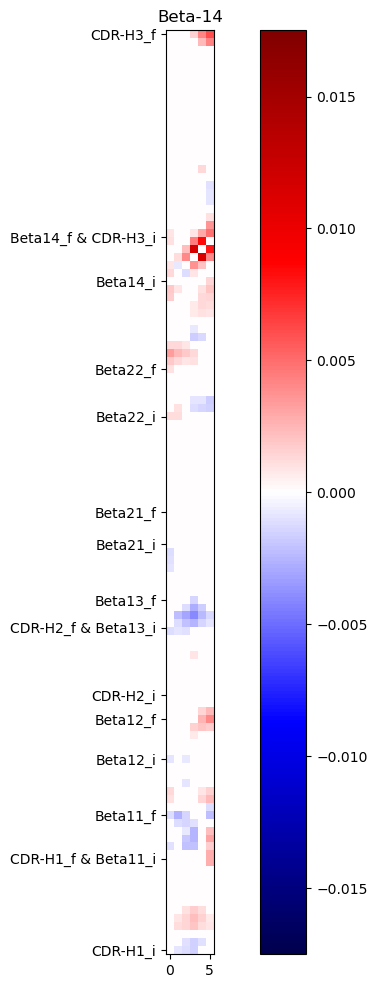

0.11494464435315471


In [133]:
plt.figure(figsize=(12, 12))
beta14_corr = masked_img[:, beta14_coord]
plt.imshow(np.where(abs(beta14_corr)<abs(beta14_corr).max()/15, 0, beta14_corr), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-14')
plt.show()
print(beta14_corr.sum())

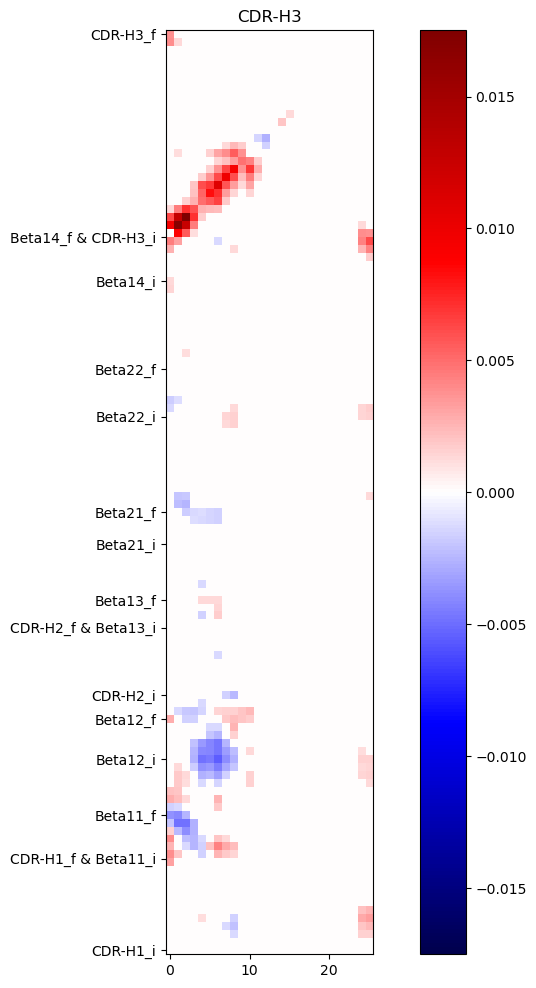

0.3349156906551082


In [134]:
plt.figure(figsize=(12, 12))
cdr3_corr = masked_img[:, cdr3_coord]
plt.imshow(np.where(abs(cdr3_corr)<abs(cdr3_corr).max()/15, 0, cdr3_corr), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('CDR-H3')
plt.show()
print(cdr3_corr.sum())

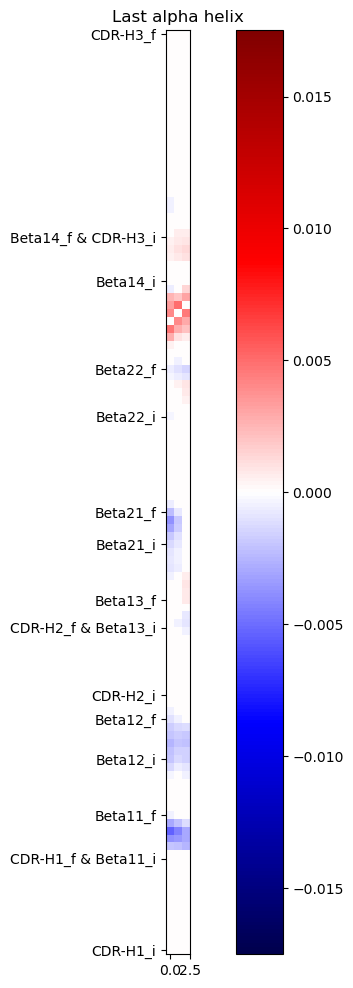

-0.04215811407670835


In [135]:
plt.figure(figsize=(12, 12))
alpha_corr = masked_img[:, alpha_coord]
plt.imshow(np.where(abs(alpha_corr)<abs(alpha_corr).max()/15, 0, alpha_corr), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Last alpha helix')
plt.show()
print(alpha_corr.sum())

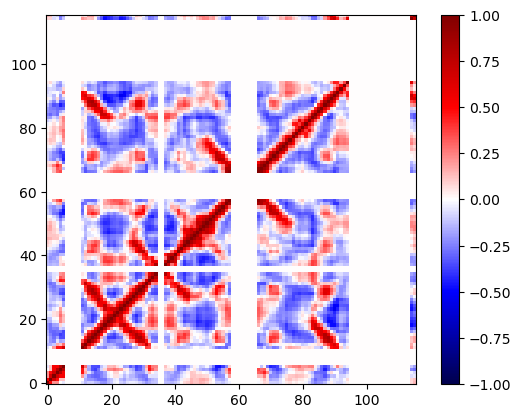

In [281]:
# expanded version 
cdr3_factor = 0.1 
cdr1_factor = 0.1 
cdr2_factor = 0.1 
beta11_factor = 0.1 
beta12_factor = 0.1 
beta13_factor = 0.1 
beta14_factor = 0.1 
beta21_factor = 0.1 
beta22_factor = 0.1 
alpha_factor = 0.1 


weights = np.array([cdr1_factor, beta11_factor, beta12_factor, cdr2_factor, beta13_factor, beta21_factor, beta22_factor, alpha_factor, beta14_factor, cdr3_factor])
coord = np.array([cdr1_coord, beta11_coord, beta12_coord, cdr2_coord, beta13_coord, beta21_coord, beta22_coord, alpha_coord, beta14_coord, cdr3_coord], dtype=object)
maps = [cdr1_corr, beta11_corr, beta12_corr, cdr2_corr, beta13_corr, beta21_corr, beta22_corr, alpha_corr, beta14_corr, cdr3_corr]

ideal = deepcopy(test_array)

for i in range(len(weights)):
    temp = deepcopy(np.pad(maps[i], ((0, 0), (coord[i][0], train_x.shape[2]-coord[i][-1]-1))))
    ideal += np.multiply(mask, weights[i] * (temp + np.transpose(temp)) / 2) 
    #ideal += weights[i] * (temp + np.transpose(temp)) / 2
plt.imshow(ideal, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

# 1st: CDR2, CDR3, Beta11, Beta12
# 2nd: Beta13
# 3rd: CDR1, Beta 14
# 4th: Beta21, Beta22, Alpha

In [282]:
model.eval()
new_prediction = 10**model(torch.from_numpy(ideal.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32)))[0].detach().numpy()
per_change = ((prediction - new_prediction) / prediction * 100)[0][0]
print(new_prediction)
print('Kd smaller by', per_change, '%')

[[3.1258865e-06]]
Kd smaller by 4.2406535 %


## Additional checks

0.9999888418685667
1.0000579843035151
0.9995503177168537
1.0000810135585902
0.9998224375579402
1.0008751884802871
1.000308023088899
0.9982924517770881
0.9993183533631
1.0006190241747508
1.0005148899481022
1.0001061142158127
1.0009880539125915
0.9989237999509049
0.9965779504330218
0.9958611169982563
1.0015098750430482
0.9999148092458215
0.9997108496406248
0.9980892414909157
1.0005652273409378
0.9992731421060143
0.9997863341355809
1.0009497389350779
0.9998387144174354
0.996446816140192
1.0004533165869616
1.0009128460945078
0.9960120140041523
0.9963779818122365
0.9965234107599447
0.9993829607183002
1.0003464127197585
0.9993558457962151
0.9965126166096464
0.9994280747159427
1.0001001378990653
1.001150995601937
1.0000839777623203
1.0003110795531671
1.0001118118623953
1.0005062065153172
0.9996273281172648
0.9991427969059393
1.0016397986284356
0.9995199012047464
0.999853505716471
0.9998188342874578
0.9990461752995892
1.0011618676111045
1.000547047424379
1.0004283318421736
0.9989676512053993
0

0.9983995262254939
0.997906087227295
1.000121681092963
0.9993008291327758
0.999627193366212
0.9997360353125485
1.0009066252564216
0.9988055988055046
1.0000159148948253
0.999800780637531
1.0004223495730367
0.999401336274038
0.9985937260319071
0.9999963043127278
0.9979486744999657
0.9994414376476354
0.9993372980583368
0.9998482624798108
1.000434580819617
1.001415726190586
0.9997737646698731
0.9987167947396995
1.0007644795003618
0.9984897702108921
1.0000185792290979
0.9984111139144637
0.9995328288051094
1.000349517274888
0.9991204031807072
0.9990739249904564
1.000075863017618
1.0006598078640032
1.0000700855698559
0.9996662722427052
0.9994689098475622
1.0020667695502805
0.9996843640125062
1.0015995967246782
0.9995970153394111
0.9989234171467727
1.000748034526807
1.000182296360698
0.996543888032951
1.001090112898892
1.000007165017052
1.0014466530042112
0.9983340398373842
1.0008874038429234
0.9965240134318399
1.0000804169829023
0.998888692000074
0.999654673084612
0.9999458296010447
1.0010743

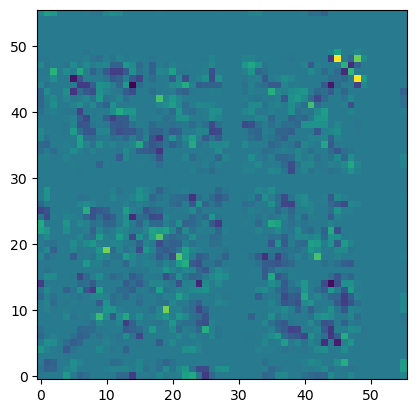

In [138]:
cont = 0
for sample in range(660):
    plt.imshow(each_img[sample], origin='lower')
    #plt.colorbar()
    print(each_img[sample].sum()/each_img_enl[sample].sum())
        

In [139]:
# Get matrix with pixel values according to importance for Kd
corr_matrix = np.zeros((116**2))
for k in range(116**2):
    alpha_beta_vec = []
    s_kds = []
    for j, i in enumerate(list(perm.detach().numpy())):
        pix_val = imgs[i].reshape(116**2)[k]
        alpha_beta_vec.append(pix_val.sum())
        s_kds.append(train_y[i,:][0].detach().numpy())
    print(k)
    corr_matrix[k] = np.corrcoef(alpha_beta_vec, s_kds)[1,0]
corr_matrix = np.nan_to_num(corr_matrix, copy=True, nan=0.0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/kevinmicha/opt/anaconda3/envs/antiberta/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/kevinmicha/opt/anaconda3/envs/antiberta/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986


2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644


4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287


5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930


7374
7375
7376
7377
7378
7379
7380
7381
7382
7383
7384
7385
7386
7387
7388
7389
7390
7391
7392
7393
7394
7395
7396
7397
7398
7399
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434
7435
7436
7437
7438
7439
7440
7441
7442
7443
7444
7445
7446
7447
7448
7449
7450
7451
7452
7453
7454
7455
7456
7457
7458
7459
7460
7461
7462
7463
7464
7465
7466
7467
7468
7469
7470
7471
7472
7473
7474
7475
7476
7477
7478
7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490
7491
7492
7493
7494
7495
7496
7497
7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573


9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
9078
9079
9080
9081
9082
9083
9084
9085
9086
9087
9088
9089
9090
9091
9092
9093
9094
9095
9096
9097
9098
9099
9100
9101
9102
9103
9104
9105
9106
9107
9108
9109
9110
9111
9112
9113
9114
9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229


10564
10565
10566
10567
10568
10569
10570
10571
10572
10573
10574
10575
10576
10577
10578
10579
10580
10581
10582
10583
10584
10585
10586
10587
10588
10589
10590
10591
10592
10593
10594
10595
10596
10597
10598
10599
10600
10601
10602
10603
10604
10605
10606
10607
10608
10609
10610
10611
10612
10613
10614
10615
10616
10617
10618
10619
10620
10621
10622
10623
10624
10625
10626
10627
10628
10629
10630
10631
10632
10633
10634
10635
10636
10637
10638
10639
10640
10641
10642
10643
10644
10645
10646
10647
10648
10649
10650
10651
10652
10653
10654
10655
10656
10657
10658
10659
10660
10661
10662
10663
10664
10665
10666
10667
10668
10669
10670
10671
10672
10673
10674
10675
10676
10677
10678
10679
10680
10681
10682
10683
10684
10685
10686
10687
10688
10689
10690
10691
10692
10693
10694
10695
10696
10697
10698
10699
10700
10701
10702
10703
10704
10705
10706
10707
10708
10709
10710
10711
10712
10713
10714
10715
10716
10717
10718
10719
10720
10721
10722
10723
10724
10725
10726
10727
10728
10729
1073

11942
11943
11944
11945
11946
11947
11948
11949
11950
11951
11952
11953
11954
11955
11956
11957
11958
11959
11960
11961
11962
11963
11964
11965
11966
11967
11968
11969
11970
11971
11972
11973
11974
11975
11976
11977
11978
11979
11980
11981
11982
11983
11984
11985
11986
11987
11988
11989
11990
11991
11992
11993
11994
11995
11996
11997
11998
11999
12000
12001
12002
12003
12004
12005
12006
12007
12008
12009
12010
12011
12012
12013
12014
12015
12016
12017
12018
12019
12020
12021
12022
12023
12024
12025
12026
12027
12028
12029
12030
12031
12032
12033
12034
12035
12036
12037
12038
12039
12040
12041
12042
12043
12044
12045
12046
12047
12048
12049
12050
12051
12052
12053
12054
12055
12056
12057
12058
12059
12060
12061
12062
12063
12064
12065
12066
12067
12068
12069
12070
12071
12072
12073
12074
12075
12076
12077
12078
12079
12080
12081
12082
12083
12084
12085
12086
12087
12088
12089
12090
12091
12092
12093
12094
12095
12096
12097
12098
12099
12100
12101
12102
12103
12104
12105
12106
12107
1210

13308
13309
13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320
13321
13322
13323
13324
13325
13326
13327
13328
13329
13330
13331
13332
13333
13334
13335
13336
13337
13338
13339
13340
13341
13342
13343
13344
13345
13346
13347
13348
13349
13350
13351
13352
13353
13354
13355
13356
13357
13358
13359
13360
13361
13362
13363
13364
13365
13366
13367
13368
13369
13370
13371
13372
13373
13374
13375
13376
13377
13378
13379
13380
13381
13382
13383
13384
13385
13386
13387
13388
13389
13390
13391
13392
13393
13394
13395
13396
13397
13398
13399
13400
13401
13402
13403
13404
13405
13406
13407
13408
13409
13410
13411
13412
13413
13414
13415
13416
13417
13418
13419
13420
13421
13422
13423
13424
13425
13426
13427
13428
13429
13430
13431
13432
13433
13434
13435
13436
13437
13438
13439
13440
13441
13442
13443
13444
13445
13446
13447
13448
13449
13450
13451
13452
13453
13454
13455


In [140]:
faulty = []
alpha_beta_vec = []
alpha_beta_vec_whole = []
s_kds = []
img1 = deepcopy(train_x.detach().numpy())
#img2 = np.repeat(masked_img, train_x.shape[0]).reshape(train_x.shape[0], train_x.shape[2], train_x.shape[3])
img2 = deepcopy(each_img_enl)

for j, i in enumerate(list(perm.detach().numpy())):
    img1[i][0] = np.multiply(mask, cv2.resize(pooling(train_x.detach().numpy()[i][0], (3,3)), dsize=(116, 116)))
    #img1[i][0] /= np.abs(img1[i][0].max())
    # img1[i][0] = cv2.resize(pooling(train_x.detach().numpy()[i][0], (2,2)), dsize=(116, 116))
    #each_img_enl[j] = np.convolve(-np.sign(mean_diff_image[0].reshape(116**2)), each_img_enl[j].reshape(116**2), 'same').reshape(116, 116)
    #alpha_beta = np.convolve(imgs[i][:,alpha_coord].reshape(116*len(alpha_coord)), masked_img[:,alpha_coord].reshape(116*len(alpha_coord)))
    #alpha_beta = (corr_matrix[:,alpha_coord]).reshape(116*len(alpha_coord))#, each_img_enl[j][:, alpha_coord].reshape(116*len(alpha_coord)))
    alpha_beta = np.convolve(img1[i][:,range(alpha_coord[0],alpha_coord[-1]+1)].reshape(116*(len(alpha_coord))), img2[j][:,range(alpha_coord[0],alpha_coord[-1]+1)].reshape(116*(len(alpha_coord))))
    cdr3_beta = np.convolve(img1[i][:,range(cdr3_coord[0],cdr3_coord[-1]+1)].reshape(116*(len(cdr3_coord))), img2[j][:,range(cdr3_coord[0],cdr3_coord[-1]+1)].reshape(116*(len(cdr3_coord))))
    cdr2_beta = np.convolve(img1[i][:,range(cdr2_coord[0],cdr2_coord[-1]+1)].reshape(116*(len(cdr2_coord))), img2[j][:,range(cdr2_coord[0],cdr2_coord[-1]+1)].reshape(116*(len(cdr2_coord))))
    cdr1_beta = np.convolve(img1[i][:,range(cdr1_coord[0],cdr1_coord[-1]+1)].reshape(116*(len(cdr1_coord))), img2[j][:,range(cdr1_coord[0],cdr1_coord[-1]+1)].reshape(116*(len(cdr1_coord))))
    beta11_beta = np.convolve(img1[i][:,range(beta11_coord[0],beta11_coord[-1]+1)].reshape(116*(len(beta11_coord))), img2[j][:,range(beta11_coord[0],beta11_coord[-1]+1)].reshape(116*(len(beta11_coord))))
    beta12_beta = np.convolve(img1[i][:,range(beta12_coord[0],beta12_coord[-1]+1)].reshape(116*(len(beta12_coord))), img2[j][:,range(beta12_coord[0],beta12_coord[-1]+1)].reshape(116*(len(beta12_coord))))
    beta13_beta = np.convolve(img1[i][:,range(beta13_coord[0],beta13_coord[-1]+1)].reshape(116*(len(beta13_coord))), img2[j][:,range(beta13_coord[0],beta13_coord[-1]+1)].reshape(116*(len(beta13_coord))))
    beta14_beta = np.convolve(img1[i][:,range(beta14_coord[0],beta14_coord[-1]+1)].reshape(116*(len(beta14_coord))), img2[j][:,range(beta14_coord[0],beta14_coord[-1]+1)].reshape(116*(len(beta14_coord))))
    beta21_beta = np.convolve(img1[i][:,range(beta21_coord[0],beta21_coord[-1]+1)].reshape(116*(len(beta21_coord))), img2[j][:,range(beta21_coord[0],beta21_coord[-1]+1)].reshape(116*(len(beta21_coord))))
    beta22_beta = np.convolve(img1[i][:,range(beta22_coord[0],beta22_coord[-1]+1)].reshape(116*(len(beta22_coord))), img2[j][:,range(beta22_coord[0],beta22_coord[-1]+1)].reshape(116*(len(beta22_coord))))
    alpha_beta_vec.append(alpha_beta.sum()+cdr3_beta.sum()+cdr1_beta.sum()+cdr2_beta.sum()+beta11_beta.sum()+beta12_beta.sum()+beta13_beta.sum()+beta14_beta.sum()+beta21_beta.sum()+beta22_beta.sum())
    alpha_beta_vec_whole.append(np.convolve(img1[i].reshape(116**2), img2[j].reshape(116**2)).sum())
    s_kds.append(train_y[i,:][0].detach().numpy())
    #print(mean_beta.sum())
#plt.colorbar()

# 1st: CDR2, Beta14, CDR3, Beta12
# 2nd: CDR1, Beta21
# 3rd: Alpha, Beta13
# 4th: Beta11, Beta22

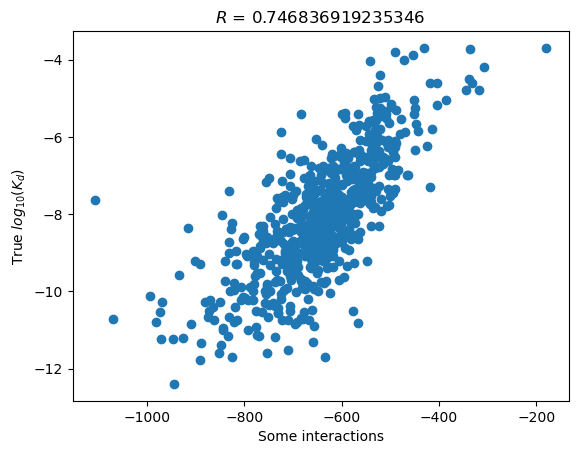

In [141]:
plt.scatter(alpha_beta_vec, s_kds)
corr = np.corrcoef(alpha_beta_vec, s_kds)[1,0]
plt.title('$R$ = '+str(corr))
plt.xlabel('Some interactions')
plt.ylabel('True $log_{10}$($K_d$)')
plt.show()

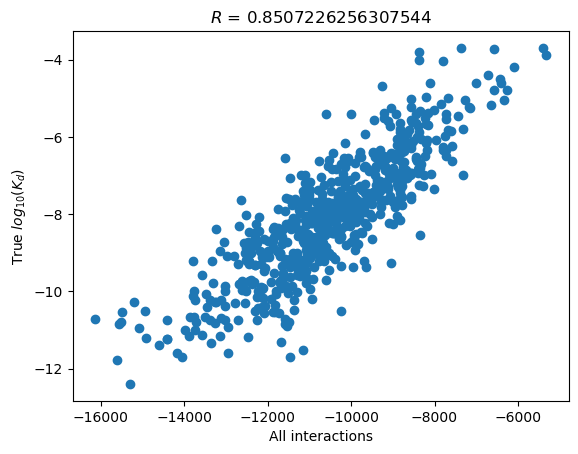

In [142]:
plt.scatter(alpha_beta_vec_whole, s_kds)
corr = np.corrcoef(alpha_beta_vec_whole, s_kds)[1,0]
plt.title('$R$ = '+str(corr))
plt.xlabel('All interactions')
plt.ylabel('True $log_{10}$($K_d$)')
plt.show()

In [143]:
faulty = []
alpha_beta_vec = []
s_kds = []
img1 = deepcopy(train_x.detach().numpy())
#img2 = np.repeat(masked_img, train_x.shape[0]).reshape(train_x.shape[0], train_x.shape[2], train_x.shape[3])
img2 = deepcopy(each_img_enl)

for j, i in enumerate(list(perm.detach().numpy())):
    #img1[i] = np.multiply(np.sign(img2[j]), np.multiply(mask, img1[i]))
    #each_img_enl[j] = np.convolve(-np.sign(mean_diff_image[0].reshape(116**2)), each_img_enl[j].reshape(116**2), 'same').reshape(116, 116)
    #alpha_beta = np.convolve(imgs[i][:,alpha_coord].reshape(116*len(alpha_coord)), masked_img[:,alpha_coord].reshape(116*len(alpha_coord)))
    #alpha_beta = (corr_matrix[:,alpha_coord]).reshape(116*len(alpha_coord))#, each_img_enl[j][:, alpha_coord].reshape(116*len(alpha_coord)))
    alpha_beta = img2[j][:,range(alpha_coord[0],alpha_coord[-1]+1)].reshape(116*(len(alpha_coord)))
    cdr3_beta = img2[j][:,range(cdr3_coord[0],cdr3_coord[-1]+1)].reshape(116*(len(cdr3_coord)))
    cdr2_beta = img2[j][:,range(cdr2_coord[0],cdr2_coord[-1]+1)].reshape(116*(len(cdr2_coord)))
    cdr1_beta = img2[j][:,range(cdr1_coord[0],cdr1_coord[-1]+1)].reshape(116*(len(cdr1_coord)))
    beta11_beta = img2[j][:,range(beta11_coord[0],beta11_coord[-1]+1)].reshape(116*(len(beta11_coord)))
    beta12_beta = img2[j][:,range(beta12_coord[0],beta12_coord[-1]+1)].reshape(116*(len(beta12_coord)))
    beta13_beta = img2[j][:,range(beta13_coord[0],beta13_coord[-1]+1)].reshape(116*(len(beta13_coord)))
    beta14_beta = img2[j][:,range(beta14_coord[0],beta14_coord[-1]+1)].reshape(116*(len(beta14_coord)))
    beta21_beta = img2[j][:,range(beta21_coord[0],beta21_coord[-1]+1)].reshape(116*(len(beta21_coord)))
    beta22_beta = img2[j][:,range(beta22_coord[0],beta22_coord[-1]+1)].reshape(116*(len(beta22_coord)))
    alpha_beta_vec.append(alpha_beta.sum()+cdr3_beta.sum()+cdr1_beta.sum()+cdr2_beta.sum()+beta11_beta.sum()+beta12_beta.sum()+beta13_beta.sum()+beta14_beta.sum()+beta21_beta.sum()+beta22_beta.sum())
    #alpha_beta_vec.append(np.multiply(img1[i].reshape(116**2), img2.reshape(116**2)).sum())
    s_kds.append(train_y[i,:][0].detach().numpy())
    #print(mean_beta.sum())
#plt.colorbar()

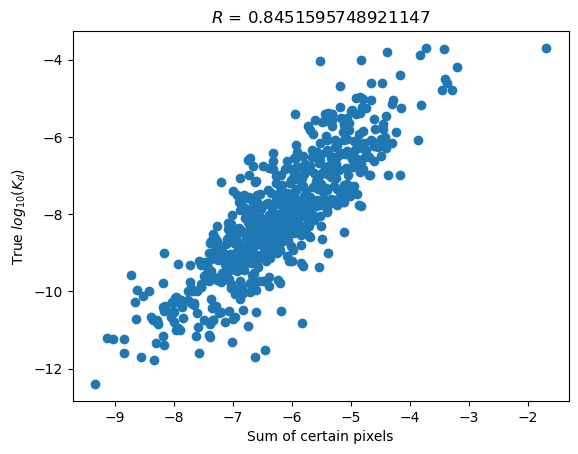

In [144]:
plt.scatter(alpha_beta_vec, s_kds)
corr = np.corrcoef(alpha_beta_vec, s_kds)[1,0]
plt.title('$R$ = '+str(corr))
plt.xlabel('Sum of certain pixels')
plt.ylabel('True $log_{10}$($K_d$)')
plt.show()

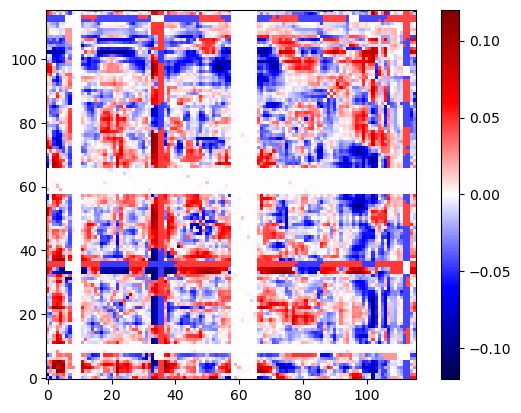

In [147]:
plt.imshow(corr_matrix.reshape(116, 116), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

In [146]:
s_kds

[array(-6.154902, dtype=float32),
 array(-9.244125, dtype=float32),
 array(-8.721247, dtype=float32),
 array(-8.366531, dtype=float32),
 array(-7.69897, dtype=float32),
 array(-5.6382723, dtype=float32),
 array(-7.69897, dtype=float32),
 array(-8.39794, dtype=float32),
 array(-9., dtype=float32),
 array(-7.7399287, dtype=float32),
 array(-9.346787, dtype=float32),
 array(-8.823909, dtype=float32),
 array(-8.30103, dtype=float32),
 array(-8.49485, dtype=float32),
 array(-4.39794, dtype=float32),
 array(-7.1366773, dtype=float32),
 array(-5.920819, dtype=float32),
 array(-9.034799, dtype=float32),
 array(-8.481486, dtype=float32),
 array(-7.4436975, dtype=float32),
 array(-10.008774, dtype=float32),
 array(-5., dtype=float32),
 array(-7.39794, dtype=float32),
 array(-8.30103, dtype=float32),
 array(-8.686132, dtype=float32),
 array(-7.5622497, dtype=float32),
 array(-6.779892, dtype=float32),
 array(-9.126679, dtype=float32),
 array(-6.7447276, dtype=float32),
 array(-5.0231915, dtype=fl

In [ ]:
## Save Neural Network checkpoint
#EPOCH = len(val_losses)
#PATH = "model.pt"
#TR_LOSS = train_losses
#VAL_LOSS = val_losses
#
#torch.save({
#            'epoch': EPOCH,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'tr_loss': TR_LOSS,
#            'val_loss': VAL_LOSS,            
#            }, PATH)

In [63]:
# Load Neural Network checkpoint

PATH = "model_complete.pt"
model = MultiLabelNN()
optimizer = AdaBelief(model.parameters(), lr=7e-4, eps=1e-8, weight_decouple=False)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_losses = checkpoint['tr_loss']
val_losses = checkpoint['val_loss']
optimizer.param_groups[0]['lr'] = 7e-4
#model.eval()
#10**model(test_sample).detach().numpy()
# - or -
#model.train()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Rectification enabled in AdaBelief


In [ ]:
# Save Neural Network visualization

#x_val = Variable(val_x)
#model = MultiLabelNN()
#yhat = model(x_val)
#make_dot(yhat, params=dict(list(model.named_parameters()))).render("attached", format="png")

## 1kel vs 1fl6

In [148]:
bad_logkd, bad_output_filter = model(torch.from_numpy(imgs[23].reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32)))
good_logkd, good_output_filter = model(torch.from_numpy(imgs[42].reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32)))

In [149]:
good_enl = np.zeros((train_x.shape[2], train_x.shape[3]))

for i in range(n_filters):
    good_enl += ((56/116) ** 2) * cv2.resize(np.multiply(good_output_filter.detach().numpy()[0][i], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[i].reshape(size_le, size_le)), dsize=(116,116))

good_enl = np.multiply(good_enl, imgs[42]-mean_image)

In [150]:
bad_enl = np.zeros((train_x.shape[2], train_x.shape[3]))

for i in range(n_filters):
    bad_enl += ((56/116) ** 2) * cv2.resize(np.multiply(bad_output_filter.detach().numpy()[0][i], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[i].reshape(size_le, size_le)), dsize=(116,116))

bad_enl = np.multiply(bad_enl, imgs[23]-mean_image)

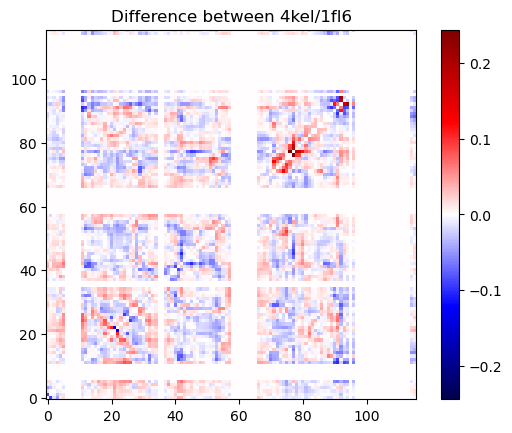

In [151]:
plt.imshow(imgs[42]-imgs[23], origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Difference between 4kel/1fl6')
plt.colorbar()
plt.show()

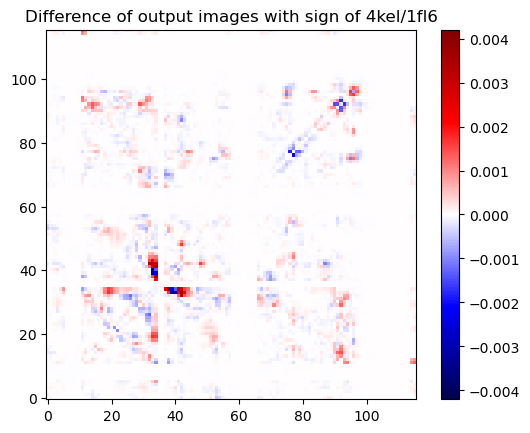

In [152]:
plt.imshow(good_enl-bad_enl, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Difference of output images with sign of 4kel/1fl6')
plt.colorbar()
plt.show()

## 1p2c vs 1mlc

In [153]:
bad_logkd, bad_output_filter = model(torch.from_numpy(imgs[52].reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32)))
good_logkd, good_output_filter = model(torch.from_numpy(imgs[68].reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32)))

In [154]:
good_enl = np.zeros((train_x.shape[2], train_x.shape[3]))

for i in range(n_filters):
    good_enl += ((56/116) ** 2) * cv2.resize(np.multiply(good_output_filter.detach().numpy()[0][i], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[i].reshape(size_le, size_le)), dsize=(116,116))

good_enl = np.multiply(good_enl, imgs[68]-mean_image)

In [155]:
bad_enl = np.zeros((train_x.shape[2], train_x.shape[3]))

for i in range(n_filters):
    bad_enl += ((56/116) ** 2) * cv2.resize(np.multiply(bad_output_filter.detach().numpy()[0][i], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[i].reshape(size_le, size_le)), dsize=(116,116))

bad_enl = np.multiply(bad_enl, imgs[52]-mean_image)

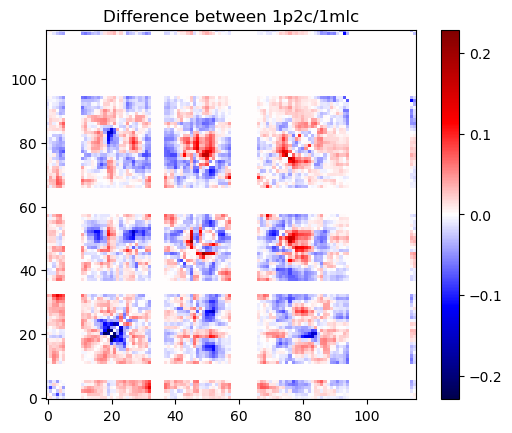

In [156]:
plt.imshow(imgs[68]-imgs[52], origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Difference between 1p2c/1mlc')
plt.colorbar()
plt.show()

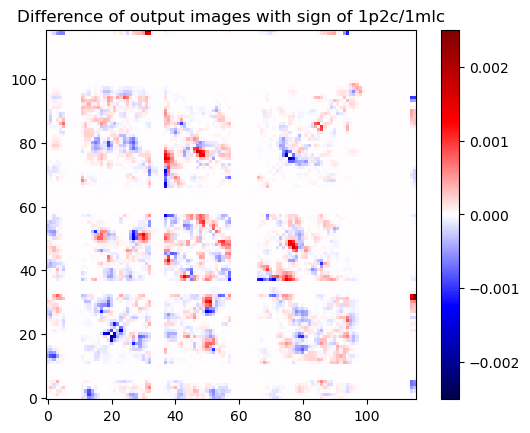

In [157]:
plt.imshow(good_enl-bad_enl, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Difference of output images with sign of 1p2c/1mlc')
plt.colorbar()
plt.show()

## 4fab vs 1t66

In [158]:
# Matured
entry = '4fab'
download_path = '/Users/kevinmicha/Downloads/'
file_name = entry + numbering + selection
path = folder + file_name + file_type_input
new_path = download_path + entry + '_map'
generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input, lresidues=False)  
subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))

if os.path.exists(path):
    os.remove(path)
h, l = np.load(download_path + 'value.npy') 

f = download_path + entry + '_map' + '.npy'
res_path = np.array([download_path + entry + '_residues' + '.npy'])
m_test_array, mask = generate_masked_image(np.load(f), idx=0, res_list=max_res_list, file_residues_paths=res_path, mode='fully-extended')
matured_sample = torch.from_numpy(m_test_array.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))

In [159]:
# Germline
entry = '1t66'
download_path = '/Users/kevinmicha/Downloads/'
file_name = entry + numbering + selection
path = folder + file_name + file_type_input
new_path = download_path + entry + '_map'
generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input, lresidues=False)  
subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))

if os.path.exists(path):
    os.remove(path)
h, l = np.load(download_path + 'value.npy') 

f = download_path + entry + '_map' + '.npy'
res_path = np.array([download_path + entry + '_residues' + '.npy'])
g_test_array, mask = generate_masked_image(np.load(f), idx=0, res_list=max_res_list, file_residues_paths=res_path, mode='fully-extended')
germline_sample = torch.from_numpy(g_test_array.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))

In [160]:
model.eval()
germline_logkd, germline_output_filter = model(germline_sample)
matured_logkd, matured_output_filter = model(matured_sample)
print('log10(K_D) is ' + str(germline_logkd.item()) + ' for 1t66 (naïve) and ' + 
     str(matured_logkd.item()) + ' for 4fab (matured).')

log10(K_D) is -5.486207962036133 for 1t66 (naïve) and -8.089019775390625 for 4fab (matured).


In [192]:
file_paths[324]

'/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/4fab.npy'

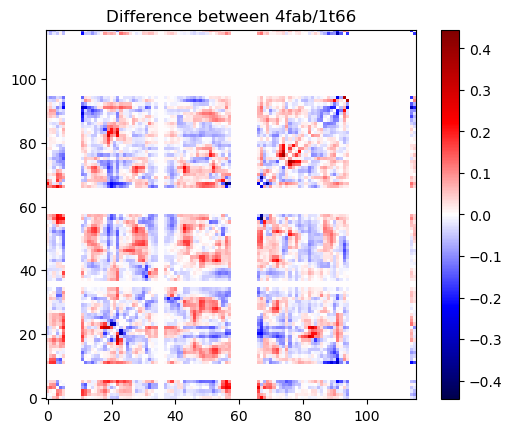

In [161]:
plt.imshow((matured_sample-germline_sample).detach().numpy()[0,0,...], origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Difference between 4fab/1t66')
plt.colorbar()
plt.show()

In [162]:
germline_enl = np.zeros((train_x.shape[2], train_x.shape[3]))

for i in range(n_filters):
    germline_enl += ((56/116) ** 2) * cv2.resize(np.multiply(germline_output_filter.detach().numpy()[0][i], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[i].reshape(size_le, size_le)), dsize=(116,116))

germline_enl = np.multiply(germline_enl, germline_sample.detach().numpy()[0,0]-mean_image)

In [163]:
matured_enl = np.zeros((train_x.shape[2], train_x.shape[3]))

for i in range(n_filters):
    matured_enl += ((56/116) ** 2) * cv2.resize(np.multiply(matured_output_filter.detach().numpy()[0][i], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[i].reshape(size_le, size_le)), dsize=(116,116))

matured_enl = np.multiply(matured_enl, matured_sample.detach().numpy()[0,0]-mean_image)

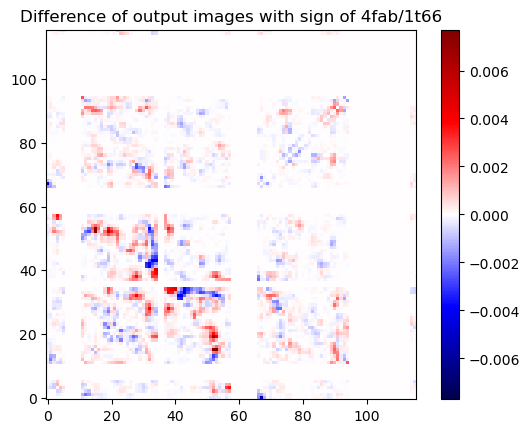

In [164]:
plt.imshow(np.multiply(mask, matured_enl-germline_enl), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Difference of output images with sign of 4fab/1t66')
plt.colorbar()
plt.show()

## Contact maps

In [165]:
import mdtraj as md
from contact_map import ContactFrequency, ContactDifference

In [166]:
entries = list(df['pdb'])
numbering = ''
selection = '_CDR1_to_CDR3'
folder = str(Path.home() / 'Downloads') + '/all_structures/chothia/'
file_type_input = '.pdb'
contact_maps = np.zeros((len(entries), train_x.shape[2], train_x.shape[3]))

# Uncomment to generate all the contact maps

#for i, entry in enumerate(entries):
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input) 
#    if entry in selected_entries:
#        idx = entries.index(entry)
#        idx_new = selected_entries.index(entry)
#        traj = md.load(path)
#        contact_maps[i] = generate_masked_image(ContactFrequency(traj).residue_contacts.sparse_matrix.toarray(), idx_new, max_res_list, file_residues_paths, 'fully-extended')[0]
#
#
#    if os.path.exists(path):
#        os.remove(path)

In [167]:
contact_maps = np.load('chain_lengths/contact_maps.npy')

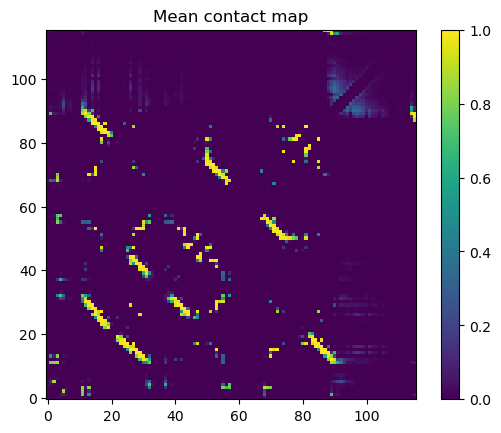

In [168]:
plt.imshow(np.mean(contact_maps, axis=0), origin='lower')
plt.title('Mean contact map')
plt.colorbar()

In [169]:
entry = '1t66'
download_path = '/Users/kevinmicha/Downloads/'
file_name = entry + numbering + selection
path = folder + file_name + file_type_input
new_path = download_path + entry + '_map'
generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input, lresidues=False)  
traj = md.load(path)
res_path = np.array([download_path + entry + '_residues' + '.npy'])
germline_cm = generate_masked_image(ContactFrequency(traj).residue_contacts.sparse_matrix.toarray(), idx=0, res_list=max_res_list, file_residues_paths=res_path, mode='fully-extended')[0]

if os.path.exists(path):
    os.remove(path)

In [170]:
entry = '4fab'
download_path = '/Users/kevinmicha/Downloads/'
file_name = entry + numbering + selection
path = folder + file_name + file_type_input
new_path = download_path + entry + '_map'
generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input, lresidues=False)  
traj = md.load(path)
matured_cm = generate_masked_image(ContactFrequency(traj).residue_contacts.sparse_matrix.toarray(), idx=0, res_list=max_res_list, file_residues_paths=res_path, mode='fully-extended')[0]

if os.path.exists(path):
    os.remove(path)

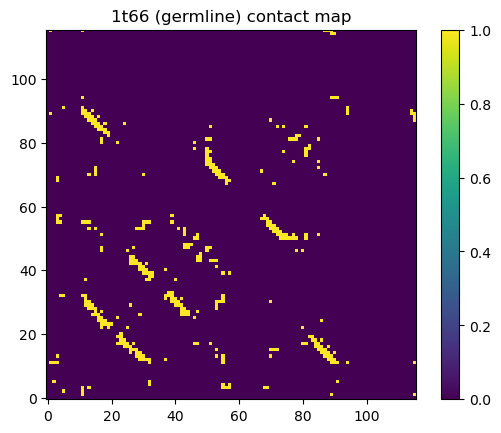

In [171]:
plt.imshow(germline_cm, origin='lower')
plt.title('1t66 (germline) contact map')
plt.colorbar()

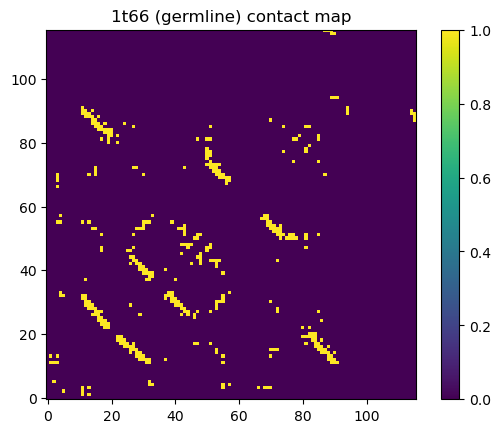

In [172]:
plt.imshow(matured_cm, origin='lower')
plt.title('1t66 (germline) contact map')
plt.colorbar()

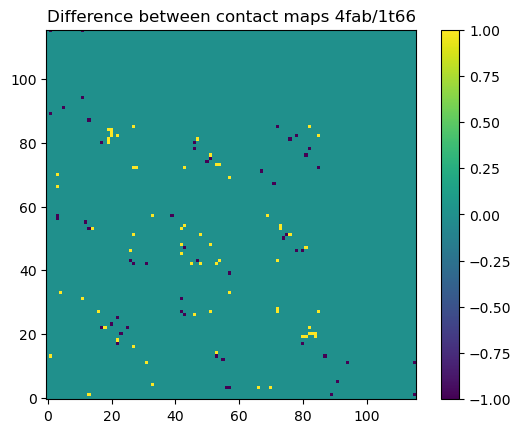

In [173]:
plt.imshow(matured_cm-germline_cm, origin='lower')
plt.title('Difference between contact maps 4fab/1t66')
plt.colorbar()

## AlphaFold tests

In [210]:
entry = '1t66'
download_path = '/Users/kevinmicha/Downloads/'
af_pdbs_path = 'alphafold_pdbs/'
file_name = entry + '_af' + numbering + selection
path = af_pdbs_path + file_name + file_type_input
new_path = af_pdbs_path + entry + '_map' 

res_path = np.array([download_path + entry + '_residues' + '.npy'])
mchain = np.load(res_path[0])

generate_cdr1_to_cdr3_pdb(af_pdbs_path+entry+numbering+'_af'+file_type_input, lresidues=False, upsymchain=26+len(mchain)-2)  
subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))

if os.path.exists(path):
    os.remove(path)

f = af_pdbs_path + entry + '_map' + '.npy'
test_array_af, mask = generate_masked_image(np.load(f), idx=0, res_list=max_res_list, file_residues_paths=res_path, mode='fully-extended')
test_sample_af = torch.from_numpy(test_array_af.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))

# this value should be in the -7 to -4 interval
model.eval()
model(test_sample_af)[0]

tensor([[-5.5337]], grad_fn=<MmBackward0>)

In [211]:
prediction = 10**model(test_sample_af)[0].detach().numpy()
prediction

array([[2.9259097e-06]], dtype=float32)

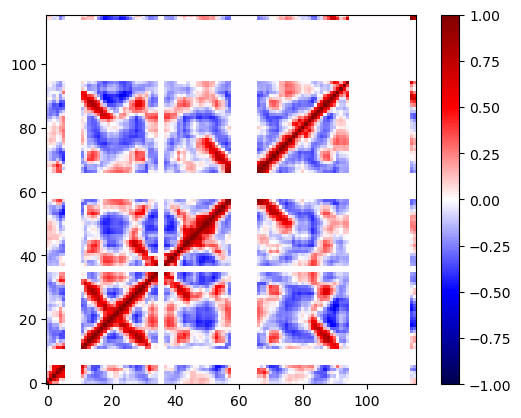

In [212]:
plt.imshow(test_array_af, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()

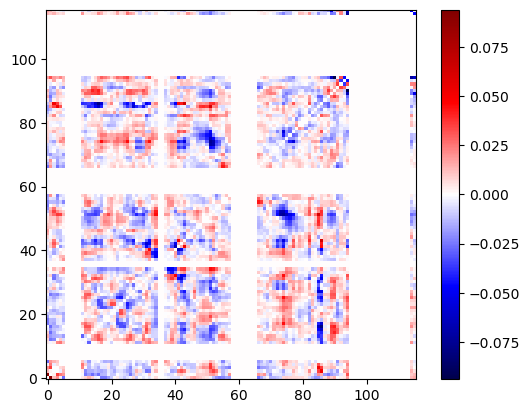

In [213]:
plt.imshow(test_array-test_array_af, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.colorbar()